# **Neuroscience Project Group 3**

### By Alisia Sara Baielli, Irene Maria Colombo, Marian Gloser, Emanuele Marino Librandi, Andrey Ralchev

# **Research question:**
**How does neuronal spike activity vary across different brain regions in response to specific stimuli in mice, and can these variations be accurately classified to map functional brain regions?**

# **1 - Imports & Useful Functions**

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import math
import ipywidgets as widgets
import matplotlib.pyplot as plt

In [2]:
from pandas.plotting import scatter_matrix
from collections import Counter
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from mpl_toolkits.mplot3d import Axes3D
from sklearn import linear_model, decomposition
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, mean_squared_error, precision_score, recall_score, confusion_matrix, roc_curve, auc, make_scorer, balanced_accuracy_score, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, cross_val_score, cross_val_predict, train_test_split
from sklearn.utils import shuffle, resample
from sklearn.dummy import DummyClassifier
from scipy.stats import loguniform
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer

In [3]:
def get_spikes_in_time_interval(regionstr, time_start, time_end, session):
    #Filter neurons in the desired region
    #IDs of these neuron are set as the indices of the units table
    region_ids = session.units[session.units["ecephys_structure_acronym"]==regionstr].index.values

    #Get the spike times as a list of numpy arrays instead of dictionary
    #spike_times[id] is a numpy array
    region_spikes = []
    for id in region_ids:
        #Filter spikes in the interval (time_start, time_end) ms.
        #A single neuron can have 20000 spikes, and eventplot would struggle
        spikes = session.spike_times[id]
        region_spikes.append(spikes[(spikes > time_start) & (spikes < time_end)])

    return region_spikes

In [4]:
def get_ids(region, session):
#Get the ids of the neurons in a given region
    ids = session.units[session.units["ecephys_structure_acronym"] == region].index.values
    return set(ids)

In [5]:
def get_time_bins(number, session):
    bins_dict = {}
    for id in session.units.index.values:
        bins_dict[id] = [0 for i in range(number)]
        for spike in session.spike_times[id]:
            rounded_spike = math.floor(spike) #the spike times are actually floats, so we have to round down the times
            if rounded_spike < number:
                bins_dict[id][rounded_spike] += 1
    return pd.DataFrame(data=bins_dict).T

In [6]:
def count_bins_without_spikes(id, bins):
    spike_dict = sorted(Counter(bins.loc[id].values).items())
    return (id, spike_dict[0][1])

In [7]:
def print_sparsity(df):
    sparsity = sum((df == 0).astype(int).sum())/df.size
    return sparsity

# **2 - Data**

## **2.1 - Choosing the session**

In [8]:
data_dir = "./allendata"
manifest_path = os.path.join(data_dir, "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

sessions = cache.get_session_table()
sessions.head()

published_at  specimen_id           session_type  \
id                                                                    
715093703  2019-10-03T00:00:00Z    699733581  brain_observatory_1.1   
719161530  2019-10-03T00:00:00Z    703279284  brain_observatory_1.1   
721123822  2019-10-03T00:00:00Z    707296982  brain_observatory_1.1   
732592105  2019-10-03T00:00:00Z    717038288  brain_observatory_1.1   
737581020  2019-10-03T00:00:00Z    718643567  brain_observatory_1.1   

           age_in_days sex                                    full_genotype  \
id                                                                            
715093703        118.0   M    Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt   
719161530        122.0   M    Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt   
721123822        125.0   M  Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt   
732592105        100.0   M                                            wt/wt   
737581020        108.0   M                                            wt/wt   

           unit_count  channel_count  probe_count  \
id                                                  
715093703         884           2219            6   
719161530         755           2214            6   
721123822         444           2229            6   
732592105         824           1847            5   
737581020         568           2218            6   

                                  ecephys_structure_acronyms  
id                                                            
715093703  [CA1, VISrl, nan, PO, LP, LGd, CA3, DG, VISl, ...  
719161530  [TH, Eth, APN, POL, LP, DG, CA1, VISpm, nan, N...  
721123822  [MB, SCig, PPT, NOT, DG, CA1, VISam, nan, LP, ...  
732592105       [grey, VISpm, nan, VISp, VISl, VISal, VISrl]  
737581020      [grey, VISmma, nan, VISpm, VISp, VISl, VISrl]

In [9]:
areas = []
for list in sessions.ecephys_structure_acronyms:
    for i in list:
        areas.append(i)
areas = set(areas)
areas

{'APN',
 'BMAa',
 'CA1',
 'CA2',
 'CA3',
 'COAa',
 'COApm',
 'CP',
 'DG',
 'Eth',
 'HPF',
 'IGL',
 'IntG',
 'LD',
 'LGd',
 'LGv',
 'LP',
 'LT',
 'MB',
 'MGd',
 'MGm',
 'MGv',
 'MRN',
 'NOT',
 'OLF',
 'OP',
 'PF',
 'PIL',
 'PO',
 'POL',
 'POST',
 'PP',
 'PPT',
 'PRE',
 'PoT',
 'ProS',
 'RPF',
 'RT',
 'SCig',
 'SCiw',
 'SCop',
 'SCsg',
 'SCzo',
 'SGN',
 'SUB',
 'TH',
 'VIS',
 'VISal',
 'VISam',
 'VISl',
 'VISli',
 'VISmma',
 'VISmmp',
 'VISp',
 'VISpm',
 'VISrl',
 'VL',
 'VPL',
 'VPM',
 'ZI',
 'grey',
 nan}

We decided to consider only sessions with a high count of neurons (units).

In [10]:
units = cache.get_units()

In [11]:
mask = (sessions["unit_count"] > 900)

best = []
for sid in sessions[mask].index.values:
    maskunits = (units["ecephys_session_id"] == sid)
    units_in_th = len(units[maskunits])
    print(f"Session {sid} has {units_in_th} total units")
    best.append(sid)

Session 750332458 has 902 total units
Session 757216464 has 959 total units
Session 771160300 has 930 total units
Session 794812542 has 1005 total units


These sessions are the best ones in number of units, but we also want them to be well distributed across brain areas.

In [12]:
for id in best:
    print(f"SESSION:{id}")
    count=0
    for i in areas:
        maskunits = (units["ecephys_session_id"] == id) & (i==units["ecephys_structure_acronym"])
        units_in_i = len(units[maskunits])
        if units_in_i>0:
            count+=1
            print(f"Session {id} has {units_in_i} units in {i}")
    print(count)
    print("------")


SESSION:750332458
Session 750332458 has 44 units in VISrl
Session 750332458 has 558 units in grey
Session 750332458 has 19 units in VISpm
Session 750332458 has 4 units in LGd
Session 750332458 has 16 units in CA1
Session 750332458 has 71 units in VISal
Session 750332458 has 38 units in VISl
Session 750332458 has 63 units in VISp
Session 750332458 has 2 units in IntG
Session 750332458 has 15 units in CA3
Session 750332458 has 7 units in DG
Session 750332458 has 5 units in IGL
Session 750332458 has 60 units in VISam
13
------
SESSION:757216464
Session 757216464 has 11 units in LGv
Session 757216464 has 60 units in VIS
Session 757216464 has 45 units in SGN
Session 757216464 has 3 units in MB
Session 757216464 has 41 units in SUB
Session 757216464 has 37 units in VISrl
Session 757216464 has 6 units in LGd
Session 757216464 has 112 units in CA1
Session 757216464 has 114 units in LP
Session 757216464 has 53 units in VISal
Session 757216464 has 53 units in VISl
Session 757216464 has 85 units 

Session 757216464 is the best in terms of number of units and distribution in areas of the brain.  

In [13]:
sessions.loc[757216464]

published_at                                               2019-10-03T00:00:00Z
specimen_id                                                           733457989
session_type                                              brain_observatory_1.1
age_in_days                                                               105.0
sex                                                                           M
full_genotype                                                             wt/wt
unit_count                                                                  959
channel_count                                                              2225
probe_count                                                                   6
ecephys_structure_acronyms    [LP, DG, CA3, CA1, VISrl, nan, PO, LGd, HPF, V...
Name: 757216464, dtype: object

## **2.2 - Loading and exploring the session**

We now proceed downloading the sessions we chose to do some analyses on it.

In [14]:
session_id = 757216464
oursession = cache.get_session_data(session_id, timeout=3000)

/Users/emanuelemarinolibrandi/opt/anaconda3/envs/envallen/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
/Users/emanuelemarinolibrandi/opt/anaconda3/envs/envallen/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.6.0-alpha is already loaded.
  return func(args[0], **pargs)


We start exploring our session by looking at the neurons it contains.

In [15]:
oursession.units

/Users/emanuelemarinolibrandi/opt/anaconda3/envs/envallen/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
/Users/emanuelemarinolibrandi/opt/anaconda3/envs/envallen/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.6.0-alpha is already loaded.
  return func(args[0], **pargs)
/Users/emanuelemarinolibrandi/opt/anaconda3/envs/envallen/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
/Users/emanuelemarinolibrandi/opt/anaconda3/envs/envallen/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.6.0-alpha is already loaded.
  return func(args[0], **pargs)


waveform_PT_ratio  waveform_amplitude  amplitude_cutoff  \
unit_id                                                              
951812724           0.530584          165.705150          0.064669   
951812745           0.442866          190.595730          0.000315   
951812785           0.361222          134.263155          0.000120   
951812765           0.760445          124.347795          0.002866   
951812811           0.563871           89.634870          0.002207   
...                      ...                 ...               ...   
951804296           0.210923          306.674160          0.001616   
951804325           0.319148           99.954465          0.000092   
951804346           0.417369          215.272590          0.001321   
951804528           0.886457          112.772010          0.003523   
951804366           0.639939           63.886680          0.020632   

           cluster_id  cumulative_drift   d_prime  firing_rate  \
unit_id                                                          
951812724           0            237.67  6.884674     9.194248   
951812745           2            261.61  5.568195     8.493725   
951812785           6            206.92  5.579259    24.437194   
951812765           4            331.84  5.722753     2.015055   
951812811           9            169.08  5.157968    37.454772   
...               ...               ...       ...          ...   
951804296         197             41.65  5.697925     0.687647   
951804325         202            134.30  4.619626     2.477649   
951804346         206             69.69  8.488513     0.376695   
951804528         237            241.93  5.762209     0.295374   
951804366         209            281.54  4.726206     2.024410   

           isi_violations  isolation_distance   L_ratio  ...  \
unit_id                                                  ...   
951812724        0.016578           99.937016  0.000019  ...   
951812745        0.095506           65.697146  0.002596  ...   
951812785        0.000587           86.525032  0.008332  ...   
951812765        0.019174           65.450579  0.000766  ...   
951812811        0.005522          507.037686  0.005300  ...   
...                   ...                 ...       ...  ...   
951804296        0.000000           64.966837  0.000495  ...   
951804325        0.006341           80.954185  0.000225  ...   
951804346        0.000000           92.507609  0.000001  ...   
951804528        0.000000           52.638833  0.001823  ...   
951804366        0.161476           58.271705  0.003418  ...   

           ecephys_structure_id  ecephys_structure_acronym  \
unit_id                                                      
951812724                 128.0                        MRN   
951812745                 128.0                        MRN   
951812785                 128.0                        MRN   
951812765                 128.0                        MRN   
951812811                 128.0                        MRN   
...                         ...                        ...   
951804296                 417.0                      VISrl   
951804325                 417.0                      VISrl   
951804346                 417.0                      VISrl   
951804528                 417.0                      VISrl   
951804366                 417.0                      VISrl   

           anterior_posterior_ccf_coordinate  dorsal_ventral_ccf_coordinate  \
unit_id                                                                       
951812724                             8292.0                         3663.0   
951812745                             8285.0                         3638.0   
951812785                             8274.0                         3604.0   
951812765                             8277.0                         3612.0   
951812811                             8259.0                         3552.0   
...                                      ...    

In [16]:
oursession.units.columns

Index(['waveform_PT_ratio', 'waveform_amplitude', 'amplitude_cutoff',
       'cluster_id', 'cumulative_drift', 'd_prime', 'firing_rate',
       'isi_violations', 'isolation_distance', 'L_ratio', 'local_index',
       'max_drift', 'nn_hit_rate', 'nn_miss_rate', 'peak_channel_id',
       'presence_ratio', 'waveform_recovery_slope',
       'waveform_repolarization_slope', 'silhouette_score', 'snr',
       'waveform_spread', 'waveform_velocity_above', 'waveform_velocity_below',
       'waveform_duration', 'filtering', 'probe_channel_number',
       'probe_horizontal_position', 'probe_id', 'probe_vertical_position',
       'structure_acronym', 'ecephys_structure_id',
       'ecephys_structure_acronym', 'anterior_posterior_ccf_coordinate',
       'dorsal_ventral_ccf_coordinate', 'left_right_ccf_coordinate',
       'probe_description', 'location', 'probe_sampling_rate',
       'probe_lfp_sampling_rate', 'probe_has_lfp_data'],
      dtype='object')

We check how the neurons are distributed across the brain areas and count their number in each of them.

In [17]:
oursession.units.ecephys_structure_acronym.value_counts()

LP       114
CA1      112
VISp      85
PO        80
VISam     64
VIS       60
VISal     53
VISl      53
APN       47
SGN       45
Eth       42
DG        42
SUB       41
VISrl     37
TH        18
MGm       16
CA3       13
LGv       11
ProS       7
LGd        6
NOT        5
MRN        5
MB         3
Name: ecephys_structure_acronym, dtype: int64

In [18]:
base_colormap = plt.cm.get_cmap('tab20c')
extended_colormap = plt.cm.get_cmap('tab10')
unique_areas = [i for i in set(oursession.units.ecephys_structure_acronym)]

colors = []
for i in range(len(unique_areas)):
    if i < 20:
        colors.append(base_colormap(i % 20))
    else:
        colors.append(extended_colormap(i % 10))

color_dict = {area: colors[i] for i, area in enumerate(unique_areas)}
neuron_counts = oursession.units['ecephys_structure_acronym'].value_counts()
neuron_c = [color_dict[area] for area in neuron_counts.index]

/var/folders/r2/bld_lf155710hgxgss_mfsym0000gn/T/ipykernel_5104/3562940260.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base_colormap = plt.cm.get_cmap('tab20c')
/var/folders/r2/bld_lf155710hgxgss_mfsym0000gn/T/ipykernel_5104/3562940260.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  extended_colormap = plt.cm.get_cmap('tab10')


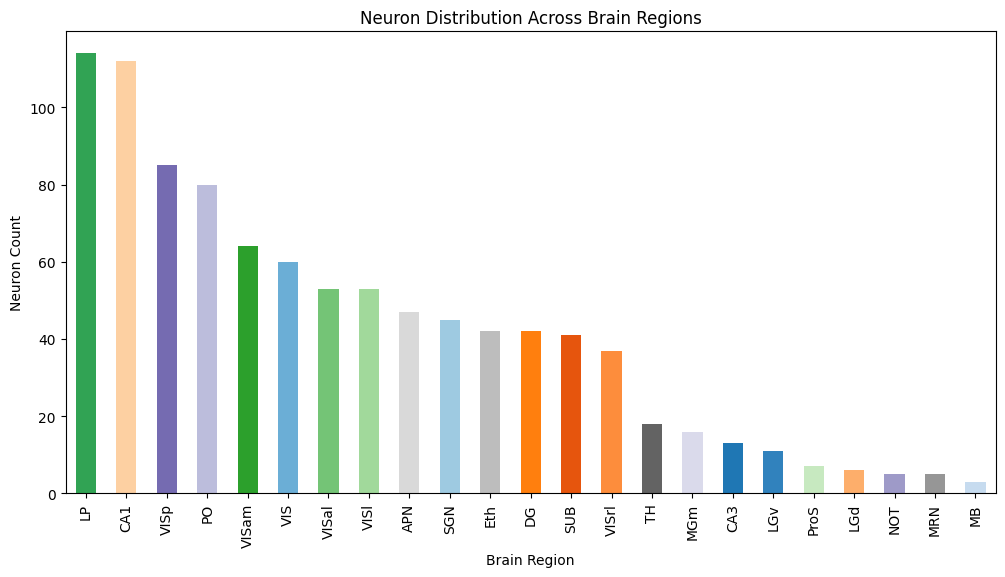

In [19]:
# Count the number of neurons in each brain region
neuron_counts = oursession.units['ecephys_structure_acronym'].value_counts()

neuron_counts.plot(kind='bar', figsize=(12, 6), color= neuron_c)
plt.title('Neuron Distribution Across Brain Regions')
plt.xlabel('Brain Region')
plt.ylabel('Neuron Count')
plt.xticks(rotation=90)
plt.show()

We now plot the firing rates against the number of neurons and we see that neurons with very high firing rates are much less common in our session

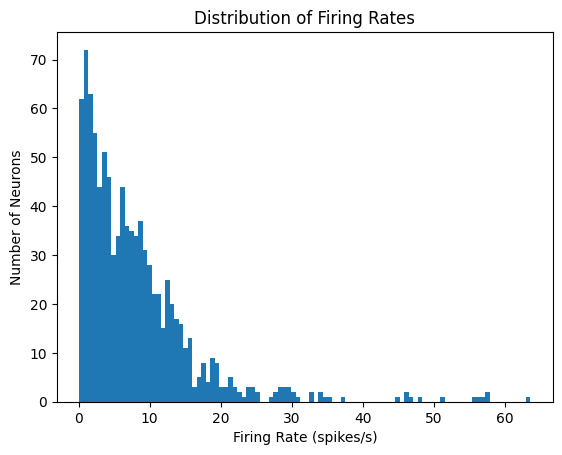

In [20]:
plt.hist(oursession.units['firing_rate'], bins=100)
plt.title('Distribution of Firing Rates')
plt.xlabel('Firing Rate (spikes/s)')
plt.ylabel('Number of Neurons')
plt.show()

We plot the histogram of ISI (interspike interval) violations, which shows that most neurons have low violation rates, which is a sign of well-isolated neurons.

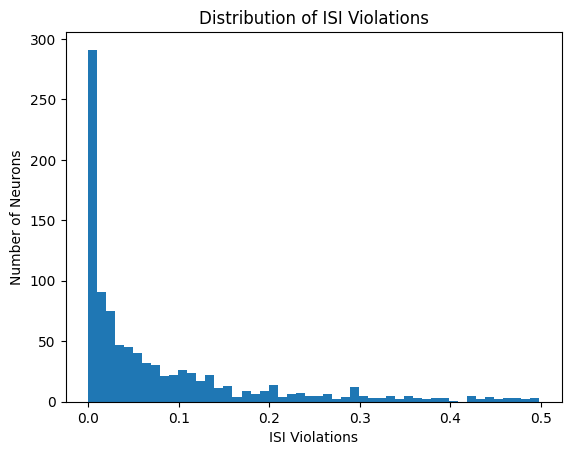

In [21]:
plt.hist(oursession.units['isi_violations'], bins=50)
plt.title('Distribution of ISI Violations')
plt.xlabel('ISI Violations')
plt.ylabel('Number of Neurons')
plt.show()

We plot the distribution of the amplitude cutoff. Lower amplitude cutoffs suggest that most neurons have spike waveforms that are less likely to be truncated.

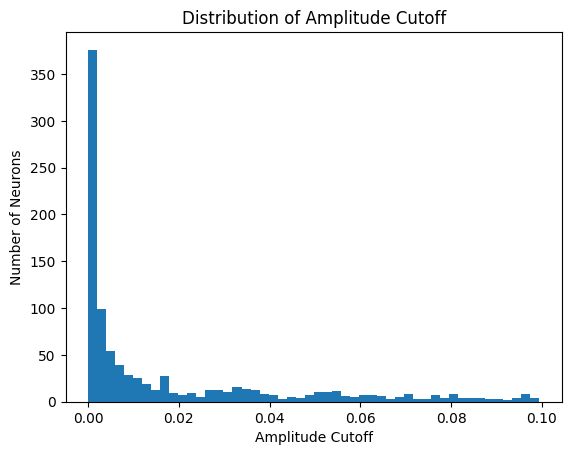

In [22]:
plt.hist(oursession.units['amplitude_cutoff'], bins=50)
plt.title('Distribution of Amplitude Cutoff')
plt.xlabel('Amplitude Cutoff')
plt.ylabel('Number of Neurons')
plt.show()

We now plot the histogram for $d'$, which measures the separability of spike waveforms. This shows a distribution skewed towards lower values. <br>

This implies that neurons have a moderate level of separability, with a few neurons having particularly high $d'$ values. <br>

High $d'$ values indicate better separability, meaning those neurons' spike waveforms are more easily distinguishable from others.

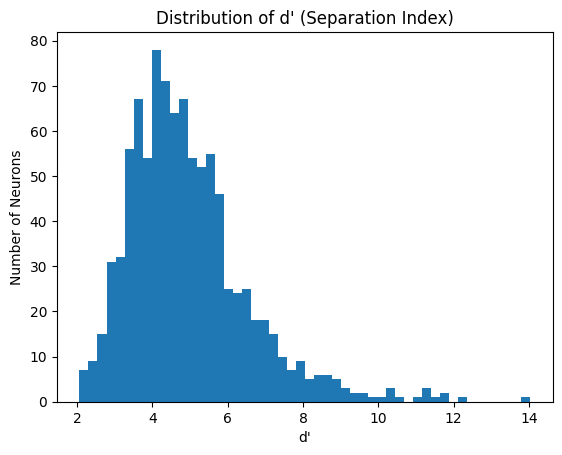

In [23]:
plt.hist(oursession.units['d_prime'], bins=50)
plt.title('Distribution of d\' (Separation Index)')
plt.xlabel('d\'')
plt.ylabel('Number of Neurons')
plt.show()

The SNR (signal-to-noise ratio) histogram shows a bell-shaped distribution skewed towards lower values. <br>

This suggests that while some neurons have a very high signal quality, most have moderate or low SNR. <br>

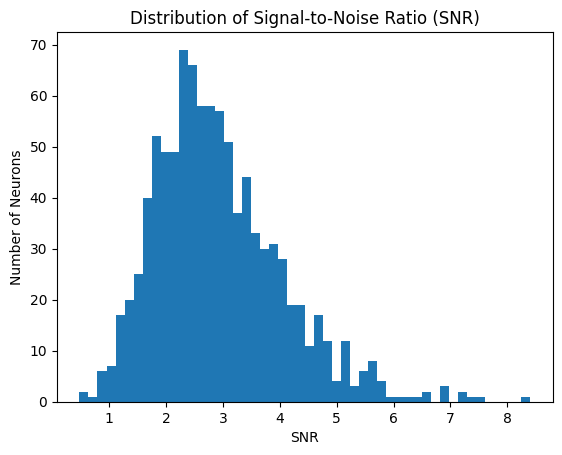

In [24]:
plt.hist(oursession.units['snr'], bins=50)
plt.title('Distribution of Signal-to-Noise Ratio (SNR)')
plt.xlabel('SNR')
plt.ylabel('Number of Neurons')
plt.show()

In [25]:
colors = plt.cm.get_cmap('nipy_spectral', len(unique_areas))
color_dict = {area: colors(i) for i, area in enumerate(unique_areas)}
neuron_colors = oursession.units['ecephys_structure_acronym'].map(color_dict)

/var/folders/r2/bld_lf155710hgxgss_mfsym0000gn/T/ipykernel_5104/989966030.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('nipy_spectral', len(unique_areas))


In [26]:
# here we define a function that shows the 3d spacial distribution of neurons, colored by brain region
def BRAIN(EL, AZ):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(
        oursession.units['anterior_posterior_ccf_coordinate'],
        oursession.units['dorsal_ventral_ccf_coordinate'],
        oursession.units['left_right_ccf_coordinate'],
        color=neuron_colors,
        s=15
    )

    for area, color in color_dict.items():
        ax.scatter([], [], [], color=color, label=area, s=15)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small', title='Brain Areas')

    ax.set_title('3D Location of Neurons', fontsize=10, pad=0.001)
    ax.set_xlabel('Anterior-Posterior Coordinate (µm)', fontsize=8, labelpad=0.001)
    ax.set_ylabel('Dorsal-Ventral Coordinate (µm)', fontsize=8, labelpad=0.001)
    ax.set_zlabel('Left-Right Coordinate (µm)', fontsize=8, labelpad=0.001)

    ax.tick_params(axis='x', labelsize=7, pad=0.001)
    ax.tick_params(axis='y', labelsize=7, pad=0.001)
    ax.tick_params(axis='z', labelsize=7, pad=0.001)

    plt.subplots_adjust(left=0.001, right=0.8, top=0.999, bottom=0.001)

    ax.view_init(elev=EL, azim=AZ)

EL_widget = widgets.IntSlider(min=0, max=90, step=1, value=30, description='Elevation:')
AZ_widget = widgets.IntSlider(min=0, max=360, step=1, value=45, description='Azimuth:')
widgets.interact(BRAIN, EL=EL_widget, AZ=AZ_widget)

interactive(children=(IntSlider(value=30, description='Elevation:', max=90), IntSlider(value=45, description='…

<function __main__.BRAIN(EL, AZ)>

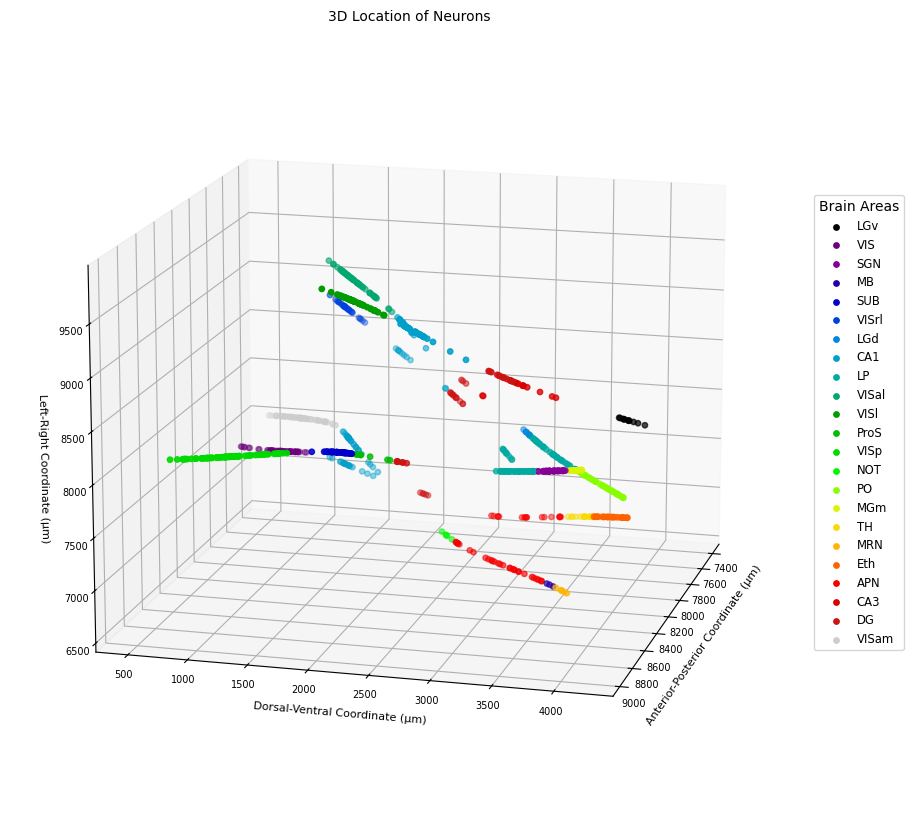

In [27]:
BRAIN(15,15)

This bar graph indicates the average number of spikes per second for neurons within each brain region. <br>

Regions with higher bars indicate higher overall neuronal activity.

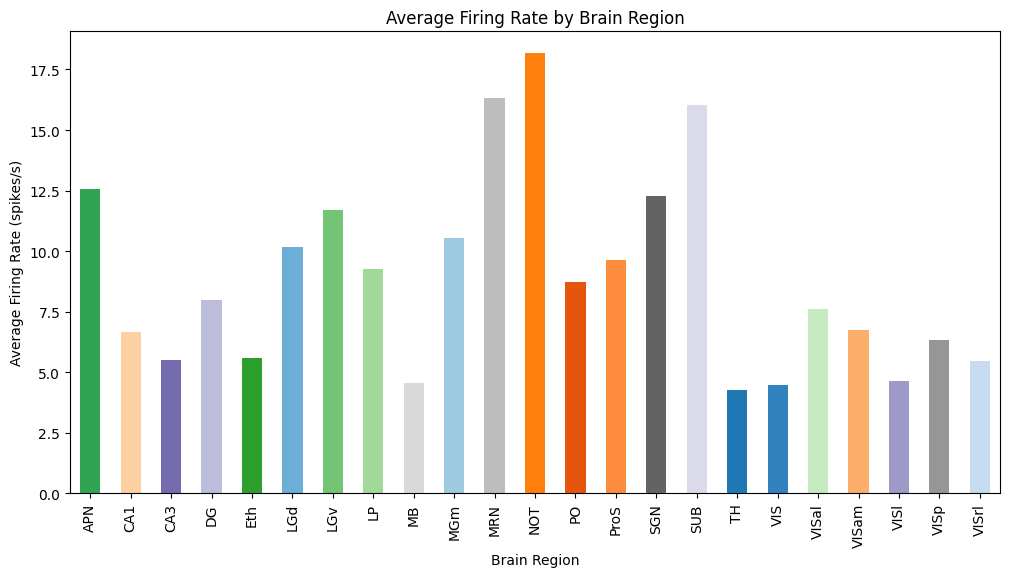

In [28]:
# Average firing rate by brain region
region_firing_rate = oursession.units.groupby('ecephys_structure_acronym')['firing_rate'].mean()
region_firing_rate.plot(kind='bar', figsize=(12, 6), color = neuron_c)
plt.title('Average Firing Rate by Brain Region')
plt.xlabel('Brain Region')
plt.ylabel('Average Firing Rate (spikes/s)')
plt.xticks(rotation=90)
plt.show()

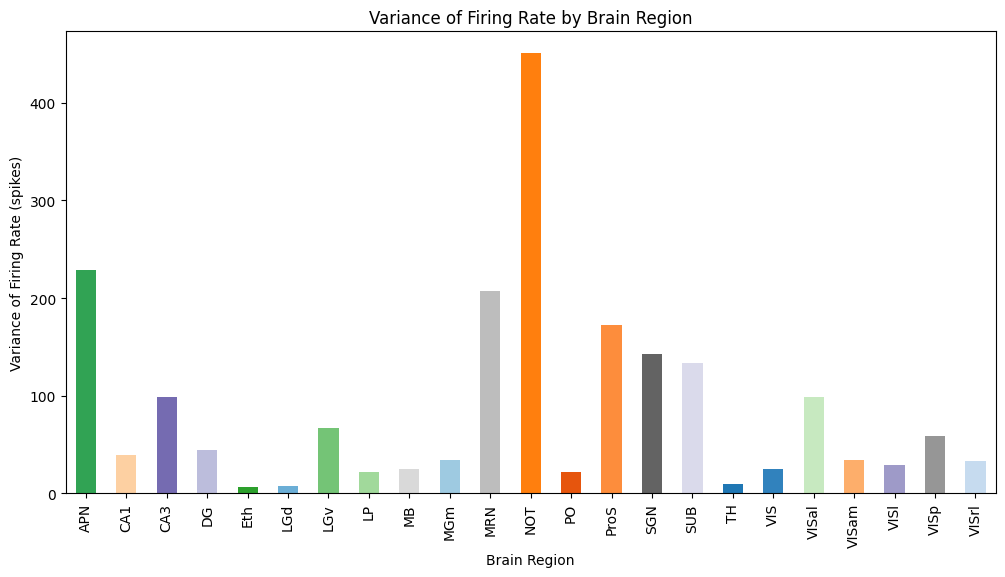

In [29]:
# Firing rate variance by brain region
region_variance = oursession.units.groupby('ecephys_structure_acronym')['firing_rate'].var()

region_variance.plot(kind='bar', figsize=(12, 6), color=neuron_c)
plt.title('Variance of Firing Rate by Brain Region')
plt.xlabel('Brain Region')
plt.ylabel('Variance of Firing Rate (spikes)')
plt.xticks(rotation=90)
plt.show()

## **2.3 - Building the dataset**

We need to build a dataset to perform our classification. We start by printing all the neurons' ids and their corresponding region labels.

In [30]:
neurons = oursession.units.index.values
print(len(neurons))
neurons

959


array([951812724, 951812745, 951812785, 951812765, 951812811, 951812829,
       951812844, 951812877, 951815918, 951812907, 951812962, 951813019,
       951813009, 951815934, 951813086, 951815944, 951813117, 951813144,
       951813169, 951813161, 951813191, 951813180, 951813227, 951813260,
       951813276, 951813294, 951813331, 951813320, 951813383, 951813406,
       951813432, 951813483, 951813535, 951813600, 951813591, 951813574,
       951813616, 951813606, 951813664, 951813711, 951813688, 951813718,
       951813750, 951813857, 951813912, 951813950, 951813976, 951814080,
       951814133, 951814124, 951814115, 951814161, 951814221, 951814203,
       951814238, 951814230, 951814340, 951814321, 951814384, 951814349,
       951814658, 951814480, 951814461, 951814451, 951814434, 951814427,
       951814542, 951814508, 951814499, 951816036, 951814632, 951814705,
       951814777, 951814760, 951814834, 951814827, 951814874, 951814839,
       951814898, 951814932, 951814919, 951814995, 

In [31]:
true_regions = oursession.units.ecephys_structure_acronym.values
print(len(true_regions))
true_regions

959


array(['MRN', 'MRN', 'MRN', 'MRN', 'MRN', 'MB', 'MB', 'MB', 'APN', 'APN',
       'APN', 'APN', 'APN', 'APN', 'APN', 'APN', 'APN', 'APN', 'APN',
       'APN', 'APN', 'APN', 'APN', 'APN', 'APN', 'APN', 'APN', 'APN',
       'APN', 'APN', 'APN', 'APN', 'APN', 'APN', 'APN', 'APN', 'APN',
       'APN', 'NOT', 'NOT', 'NOT', 'NOT', 'NOT', 'CA1', 'CA1', 'CA1',
       'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1',
       'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1',
       'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1',
       'CA1', 'VISam', 'VISam', 'VISam', 'VISam', 'VISam', 'VISam',
       'VISam', 'VISam', 'VISam', 'VISam', 'VISam', 'VISam', 'VISam',
       'VISam', 'VISam', 'VISam', 'VISam', 'VISam', 'VISam', 'VISam',
       'VISam', 'VISam', 'VISam', 'VISam', 'VISam', 'VISam', 'VISam',
       'VISam', 'VISam', 'VISam', 'VISam', 'VISam', 'VISam', 'VISam',
       'VISam', 'VISam', 'VISam', 'VISam', 'VISam', 'VISam', 'VISam',
       'VISam', 'V

We now look for the first and last spike time, so that we can construct a dataset considering the timeframe that includes all the spikes.

In [32]:
spikes_per_id = []
for id in oursession.units.index.values:
    for time in oursession.spike_times[id]:
        spikes_per_id.append(time)

print(f"The max spike time is: {max(spikes_per_id)}")
print(f"The min spike time is: {min(spikes_per_id)}")

/Users/emanuelemarinolibrandi/opt/anaconda3/envs/envallen/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
/Users/emanuelemarinolibrandi/opt/anaconda3/envs/envallen/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.6.0-alpha is already loaded.
  return func(args[0], **pargs)
/Users/emanuelemarinolibrandi/opt/anaconda3/envs/envallen/lib/python3.11/site-packages/allensdk/brain_observatory/ecephys/ecephys_session.py:1371: UserWarning: Session includes invalid time intervals that could be accessed with the attribute 'invalid_times',Spikes within these intervals are invalid and may need to be excluded from the analysis.
  warnings.warn("Session includes invalid time intervals that could "
/Users/emanuelemarinolibrandi/opt/anaconda3/envs/envallen/lib/python3.11/site-packages/hdmf/

The max spike time is: 9632.284100867188
The min spike time is: 3.751621480105144


We have to decide the number of time bins to use and the choice should be based on the max and min spike time: 10000 seems a reasonable choice.

In [33]:
time_bins = get_time_bins(10000, oursession)
time_bins

0     1     2     3     4     5     6     7     8     9     ...  \
951812724     0     0     0     1     7     3     6     5     6     6  ...   
951812745     0     0     0    22    73    54    61    62    59    64  ...   
951812785     0     0     0     7    22    22    26    22    25    26  ...   
951812765     0     0     0     0     4     2     2     2     1     2  ...   
951812811     0     0     0    12    54    51    49    54    54    50  ...   
...         ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
951804296     0     0     0     0     0     0     0     0     0     0  ...   
951804325     0     0     0     1     0     0     0     2     0     0  ...   
951804346     0     0     0     0     0     0     0     0     0     0  ...   
951804528     0     0     0     0     0     0     0     0     0     0  ...   
951804366     0     0     0     2     7     9     7     2     2     5  ...   

           9990  9991  9992  9993  9994  9995  9996  9997  9998  9999  
951812724     0     0     0     0     0     0     0     0     0     0  
951812745     0     0     0     0     0     0     0     0     0     0  
951812785     0     0     0     0     0     0     0     0     0     0  
951812765     0     0     0     0     0     0     0     0     0     0  
951812811     0     0     0     0     0     0     0     0     0     0  
...         ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  
951804296     0     0     0     0     0     0     0     0     0     0  
951804325     0     0     0     0     0     0     0     0     0     0  
951804346     0     0     0     0     0     0     0     0     0     0  
951804528     0     0     0     0     0     0     0     0     0     0  
951804366     0     0     0     0     0     0     0     0     0     0  

[959 rows x 10000 columns]

We notice that the dataframe we constructed is quite sparse, so we want to check the actual sparsity value.

In [34]:
print_sparsity(time_bins)

0.2802953076120959

For the purposes of our research project, we only want to consider one type of stimulus at a time: we start with natural scenes. So we have to filter the dataset based on the stimulus type.

In [35]:
oursession.get_stimulus_table("natural_scenes")

/Users/emanuelemarinolibrandi/opt/anaconda3/envs/envallen/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
/Users/emanuelemarinolibrandi/opt/anaconda3/envs/envallen/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.6.0-alpha is already loaded.
  return func(args[0], **pargs)


stimulus_block   start_time    stop_time  \
stimulus_presentation_id                                            
51355                               9.0  5909.726695  5909.976912   
51356                               9.0  5909.976912  5910.227130   
51357                               9.0  5910.227130  5910.477347   
51358                               9.0  5910.477347  5910.727565   
51359                               9.0  5910.727565  5910.977762   
...                                 ...          ...          ...   
68224                              13.0  8568.198272  8568.448490   
68225                              13.0  8568.448490  8568.698707   
68226                              13.0  8568.698707  8568.948925   
68227                              13.0  8568.948925  8569.199127   
68228                              13.0  8569.199127  8569.449330   

                           stimulus_name  frame  duration  \
stimulus_presentation_id                                    
51355                     natural_scenes   52.0  0.250218   
51356                     natural_scenes   55.0  0.250218   
51357                     natural_scenes   14.0  0.250218   
51358                     natural_scenes  101.0  0.250218   
51359                     natural_scenes   92.0  0.250197   
...                                  ...    ...       ...   
68224                     natural_scenes   71.0  0.250218   
68225                     natural_scenes   13.0  0.250218   
68226                     natural_scenes   21.0  0.250218   
68227                     natural_scenes  104.0  0.250202   
68228                     natural_scenes   64.0  0.250202   

                          stimulus_condition_id  
stimulus_presentation_id                         
51355                                      4908  
51356                                      4909  
51357                                      4910  
51358                                      4911  
51359                                      4912  
...                                         ...  
68224                                      4952  
68225                                      4949  
68226                                      5025  
68227                                      4975  
68228                                      4947  

[5950 rows x 7 columns]

We check the duration of the stimuli presented that come from the class we are consdiering.

In [36]:
print("Total duration of natural scenes is:")
print(oursession.get_stimulus_table("natural_scenes").duration.sum())

print("Total time in which no stimulus is presented (after the first stimulus):")
print(abs(oursession.get_stimulus_table("natural_scenes").start_time[51355] - oursession.get_stimulus_table("natural_scenes").stop_time[68228]))

Total duration of natural scenes is:
1488.744125209255
Total time in which no stimulus is presented (after the first stimulus):
2659.7226352092557


We can notice that natural scenes are (almost) all presented sequentially. Therefore, to get the responses to natural scenes stimuli we should compute the *jumps* and take all the responses in the time intervals that contain natural scenes. Checking the time stamp of each spike is too computationally expensive.

In [37]:
def compute_jumps(stimuli = "natural_scenes", session = oursession):
    start_time = [i for i in oursession.get_stimulus_table(stimuli).start_time]
    stop_time = [i for i in oursession.get_stimulus_table(stimuli).stop_time]
    jumps = []
    for i in range(len(start_time)-1):
        if stop_time[i] != start_time[i+1]:
            jumps.append((stop_time[i], start_time[i+1]))
    return jumps

In [38]:
start_time = [i for i in oursession.get_stimulus_table("natural_scenes").start_time]
stop_time = [i for i in oursession.get_stimulus_table("natural_scenes").stop_time]
j = compute_jumps()
print(f"Natural scenes begin at: {min(start_time)}")
print(f"Natural scenes end at: {max(stop_time)}")
print(f"The time intervals in which no natural scene is presented are: {j}")

Natural scenes begin at: 5909.726694578195
Natural scenes end at: 8569.44932978745
The time intervals in which no natural scene is presented are: [(6390.128164578195, 6690.379064578195), (7170.780544578194, 8041.508154578195)]


We define a function to build the dataset with the data we need, filtered by stimuli time.

In [39]:
def get_table(number, session, stimuli = "natural_scenes"):
    bins_dict = {}
    jumps = compute_jumps()
    start_time = [i for i in oursession.get_stimulus_table(stimuli).start_time]
    stop_time = [i for i in oursession.get_stimulus_table(stimuli).stop_time]

    for id in session.units.index.values:
        bins_dict[id] = [0 for i in range(number)]
        for spike in session.spike_times[id]:
            rounded_spike = math.floor(spike)
            if rounded_spike < number:
                bins_dict[id][rounded_spike] += 1

    data = pd.DataFrame(data=bins_dict).T
    for time in data.columns.values:
        if time <= math.floor(min(start_time)) or time >= math.floor(max(stop_time)):
            for id in session.units.index.values:
                data.loc[id, time] = 0

    for k in range(len(jumps)):
        for time in data.columns.values:
            if time >= math.floor(jumps[k][0]) and time <= math.floor(jumps[k][1]):
                for id in session.units.index.values:
                    data.loc[id, time] = 0
    return data

We show the dataframe we just constructed for the session we chose.

In [40]:
df = get_table(10000, oursession)
df

0     1     2     3     4     5     6     7     8     9     ...  \
951812724     0     0     0     0     0     0     0     0     0     0  ...   
951812745     0     0     0     0     0     0     0     0     0     0  ...   
951812785     0     0     0     0     0     0     0     0     0     0  ...   
951812765     0     0     0     0     0     0     0     0     0     0  ...   
951812811     0     0     0     0     0     0     0     0     0     0  ...   
...         ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
951804296     0     0     0     0     0     0     0     0     0     0  ...   
951804325     0     0     0     0     0     0     0     0     0     0  ...   
951804346     0     0     0     0     0     0     0     0     0     0  ...   
951804528     0     0     0     0     0     0     0     0     0     0  ...   
951804366     0     0     0     0     0     0     0     0     0     0  ...   

           9990  9991  9992  9993  9994  9995  9996  9997  9998  9999  
951812724     0     0     0     0     0     0     0     0     0     0  
951812745     0     0     0     0     0     0     0     0     0     0  
951812785     0     0     0     0     0     0     0     0     0     0  
951812765     0     0     0     0     0     0     0     0     0     0  
951812811     0     0     0     0     0     0     0     0     0     0  
...         ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  
951804296     0     0     0     0     0     0     0     0     0     0  
951804325     0     0     0     0     0     0     0     0     0     0  
951804346     0     0     0     0     0     0     0     0     0     0  
951804528     0     0     0     0     0     0     0     0     0     0  
951804366     0     0     0     0     0     0     0     0     0     0  

[959 rows x 10000 columns]

All the entries are zero, except the ones that represent time bins containing spikes emitted as a response to *natural scenes* stimuli: the non-zero entries can be found roughly between 5600 and 8500 (except for two jumps). We verify this with some sanity check:

In [41]:
for i in df[6395]:
    assert(i == 0)
for i in df[5600]:
    assert(i == 0)
for i in df[8700]:
    assert(i == 0)

In [42]:
df.insert(0, "label", true_regions)
df_labels = df
df = df.drop('label', axis=1)

In [43]:
df_labels

label  0  1  2  3  4  5  6  7  8  ...  9990  9991  9992  9993  \
951812724    MRN  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
951812745    MRN  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
951812785    MRN  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
951812765    MRN  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
951812811    MRN  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
...          ... .. .. .. .. .. .. .. .. ..  ...   ...   ...   ...   ...   
951804296  VISrl  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
951804325  VISrl  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
951804346  VISrl  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
951804528  VISrl  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
951804366  VISrl  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   

           9994  9995  9996  9997  9998  9999  
951812724     0     0     0     0     0     0  
951812745     0     0     0     0     0     0  
951812785     0     0     0     0     0     0  
951812765     0     0     0     0     0     0  
951812811     0     0     0     0     0     0  
...         ...   ...   ...   ...   ...   ...  
951804296     0     0     0     0     0     0  
951804325     0     0     0     0     0     0  
951804346     0     0     0     0     0     0  
951804528     0     0     0     0     0     0  
951804366     0     0     0     0     0     0  

[959 rows x 10001 columns]

For our classification model, we also need to add the labels of the neurons' brain regions.

**df** is the dataset we will use to construct our classifier.   <br>
Later on we will add more neurons from other sessions to this classifier, but for now we only use the 959 neurons of session **757216464**

# **3 - Classification**

## **3.1 - Preparing the data**

We create a train and a test set.

In [44]:
train_set, test_set = train_test_split(df_labels, test_size=0.2, random_state=8)

We create a copy of the train set (for further analysis).

In [45]:
data_train_lab = train_set.copy()
data_train = data_train_lab.iloc[:,2:]

## **3.2 - One Session model: Logistic Regression**

We start constructing our first classifier. After trying some, we chose to use the Logistic Regression, since it was the one performing better.

In [46]:
X_train, y_train = train_set.iloc[:,2:], train_set["label"]
X_test, y_test = test_set.iloc[:,2:], test_set["label"]

In [47]:
model_og = LogisticRegression().fit(X_train, y_train)

y_train_pred_og = model_og.predict(X_train)
y_test_pred_og = model_og.predict(X_test)

We decided to use balanced accuracy instead of regular accuracy as our dataset is significantly unbalanced, i.e. the classes have very different number of elements each.

In [48]:
def print_accuracy(y_train, y_test, y_training_prediction, y_test_prediction):

    train_score = balanced_accuracy_score(y_train, y_training_prediction)*100
    test_score = balanced_accuracy_score(y_test, y_test_prediction)*100

    print("Training Set Accuracy:",str(train_score)+'%')
    print("Testing Set Accuracy:",str(test_score)+'%')

In [49]:
print_accuracy(y_train, y_test, y_train_pred_og, y_test_pred_og)

Training Set Accuracy: 99.63865657694775%
Testing Set Accuracy: 37.10813250920202%


In [50]:
print("Mean cross validated score:", cross_val_score(model_og, X_train, y_train).mean())

Mean cross validated score: 0.44589593413122824


We now define a function to plot the confusion matrix reporting the accuracies across brain regions of this first model. We will use this later on also for other models as it reports significant insights. 

In [51]:
def conf_matrix(model, X_train, y_train, normalize=False):
    
    y_train_pred = cross_val_predict(model, X_train, y_train, cv=5)
    cm = confusion_matrix(y_train, y_train_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(22, 22))
    
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)#, display_labels=model.classes_)
    cmap = plt.cm.Blues
    cm_display.plot(cmap=cmap, ax=ax, colorbar=False, values_format='.2%') 
    ax.set_xticks(np.arange(len(model.classes_)))
    ax.set_yticks(np.arange(len(model.classes_)))
    ax.set_xticklabels(model.classes_)
    ax.set_yticklabels(model.classes_)
    plt.xticks(rotation=45)

    plot_height = 0.7  
    plot_bottom = 0.15  
    cbar_height = plot_height
    cbar_bottom = plot_bottom + (plot_height - cbar_height) / 2
    cbar_ax = fig.add_axes([0.95, cbar_bottom, 0.02, cbar_height])

    norm = matplotlib.colors.Normalize(vmin=np.min(cm), vmax=np.max(cm))
    sm = matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    fig.colorbar(sm, cax=cbar_ax)

    plt.show()

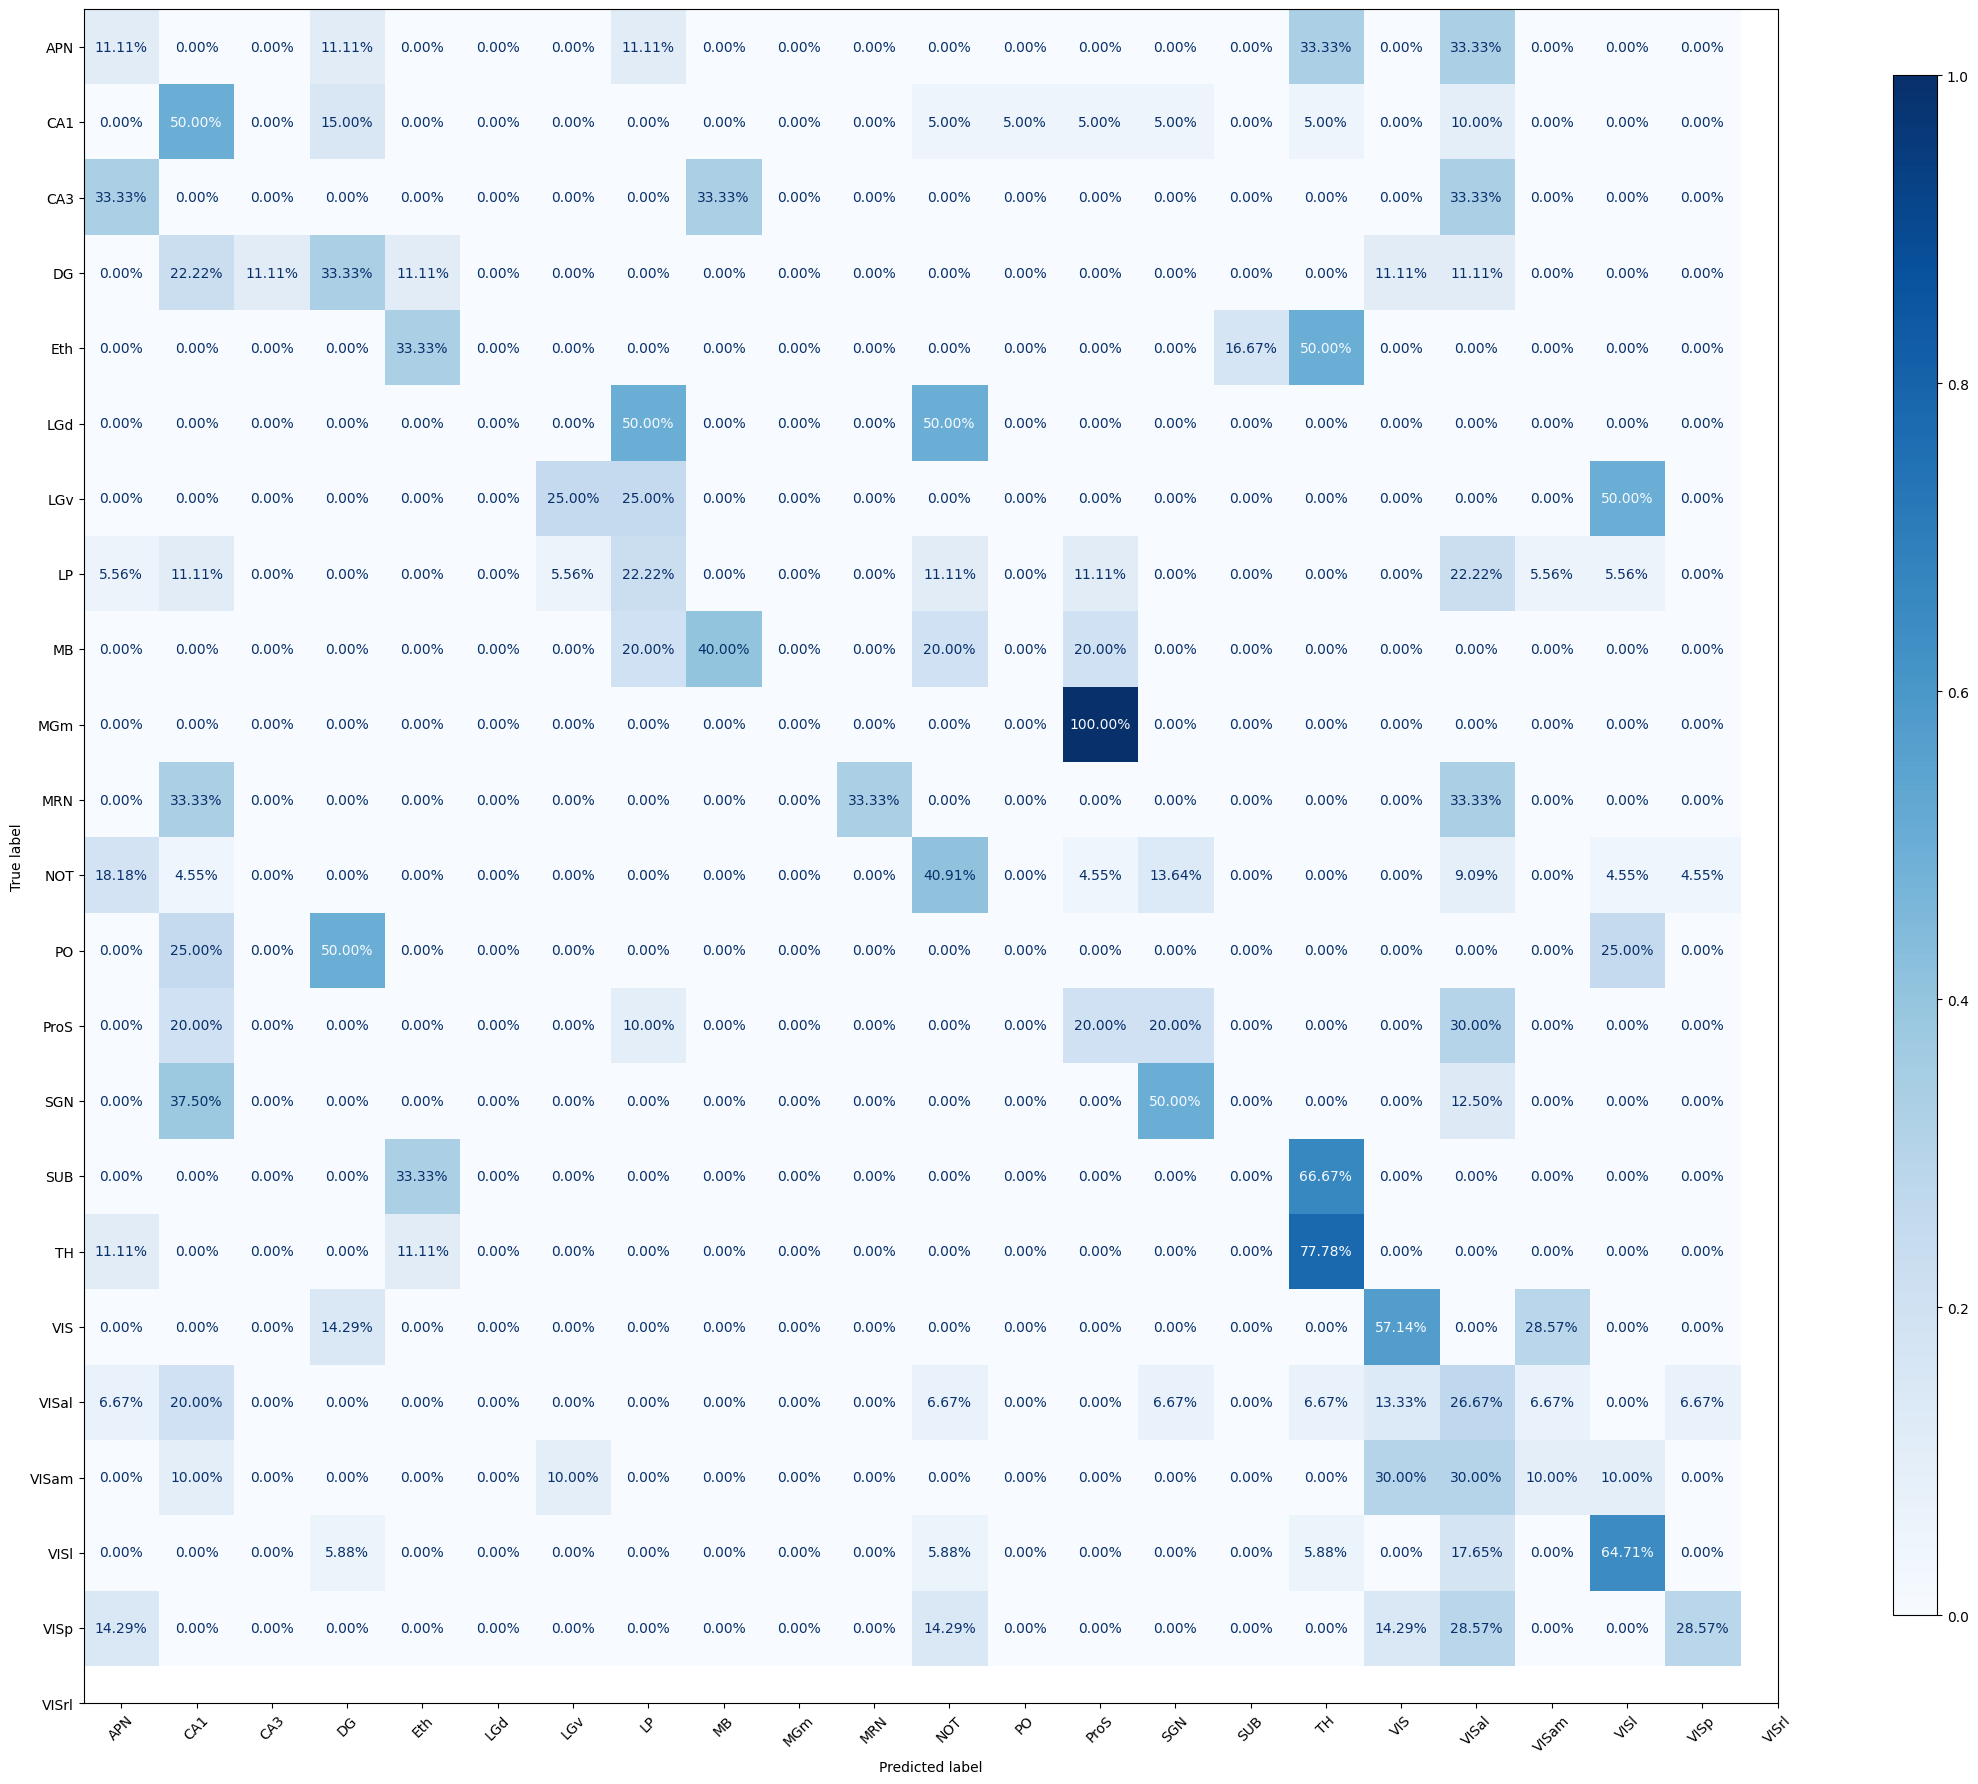

In [52]:
conf_matrix(model_og, X_test, y_test, normalize=True)

In [53]:
oursession.units.ecephys_structure_acronym.value_counts()

LP       114
CA1      112
VISp      85
PO        80
VISam     64
VIS       60
VISal     53
VISl      53
APN       47
SGN       45
Eth       42
DG        42
SUB       41
VISrl     37
TH        18
MGm       16
CA3       13
LGv       11
ProS       7
LGd        6
NOT        5
MRN        5
MB         3
Name: ecephys_structure_acronym, dtype: int64

In [54]:
y_train.value_counts()

LP       96
CA1      92
VISp     68
PO       58
VIS      51
VISam    49
VISal    46
VISl     43
APN      38
Eth      36
SGN      35
SUB      33
DG       33
VISrl    30
TH       15
MGm      11
CA3      10
LGv       7
LGd       4
MRN       4
ProS      3
MB        3
NOT       2
Name: label, dtype: int64

The Logistic Regression model, with no tuned parameter, does not perform too badly, correctly classifying more than a third of the test set.

However, there is a clear problem: there are regions in the brain with very few neurons. In this case some regions are not included in the train set. This creates a problem for the classifier: indeed, there are some classes that are not classified correctly at all. <br>
One possible solution could be just to remove those areas using some criterion. Doing so we reduce the number of neurons in our dataset, so we should add neurons from other similar sessions to improve our model.

## **3.3 - Including more sessions**

We want to find some sessions that are similar to the one we chose at first. The goal is to enlarge the dataset with new neurons.  
We seek sessions with male mice with age similar to the age of our mouse (specimen_id 733457989); moreover we want a session with at least 20 brain areas.

In [55]:
sessions_filtered = sessions[(sessions.sex == "M") & (sessions.age_in_days >= 100) & (sessions.age_in_days <= 110) & (sessions.unit_count > 600)]
sessions_filtered

published_at  specimen_id           session_type  \
id                                                                    
732592105  2019-10-03T00:00:00Z    717038288  brain_observatory_1.1   
755434585  2019-10-03T00:00:00Z    730760270  brain_observatory_1.1   
757216464  2019-10-03T00:00:00Z    733457989  brain_observatory_1.1   
757970808  2019-10-03T00:00:00Z    730756780  brain_observatory_1.1   
762120172  2019-10-03T00:00:00Z    745276236  brain_observatory_1.1   
797828357  2019-10-03T00:00:00Z    776061251  brain_observatory_1.1   

           age_in_days sex                                    full_genotype  \
id                                                                            
732592105        100.0   M                                            wt/wt   
755434585        100.0   M    Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt   
757216464        105.0   M                                            wt/wt   
757970808        106.0   M                                            wt/wt   
762120172        100.0   M    Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt   
797828357        107.0   M  Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt   

           unit_count  channel_count  probe_count  \
id                                                  
732592105         824           1847            5   
755434585         650           2220            6   
757216464         959           2225            6   
757970808         773           1853            5   
762120172         717           1860            5   
797828357         611           2232            6   

                                  ecephys_structure_acronyms  
id                                                            
732592105       [grey, VISpm, nan, VISp, VISl, VISal, VISrl]  
755434585  [grey, VISrl, nan, MGv, MGd, TH, LGd, CA3, DG,...  
757216464  [LP, DG, CA3, CA1, VISrl, nan, PO, LGd, HPF, V...  
757970808  [grey, DG, CA3, CA1, VISli, nan, MGd, SGN, LP,...  
762120172         [grey, VISal, nan, VISl, VISp, VIS, VISam]  
797828357  [PPT, MB, APN, NOT, HPF, ProS, CA1, VISam, nan...

In [56]:
regions=[]
for i in sessions_filtered.index:
    regions.append((i, sessions.loc[i, "ecephys_structure_acronyms"]))
for i in range(len(regions)):
    print(f"Session {regions[i][0]} has {len(regions[i][1])} regions")

Session 732592105 has 7 regions
Session 755434585 has 23 regions
Session 757216464 has 25 regions
Session 757970808 has 23 regions
Session 762120172 has 7 regions
Session 797828357 has 23 regions


The sessions we are interested in are: **755434585 - 757216464 -  757970808**.  


### **3.3.1 - Loading Session 755434585**



In [57]:
session_id_2 = 755434585
oursession_2 = cache.get_session_data(session_id_2)

### **3.3.2 - Combining session 755434585 and 757216464**

In [58]:
ses_2 = oursession_2.units.ecephys_structure_acronym.value_counts().to_dict()
ses_2

{'VISam': 94,
 'VISp': 75,
 'VISpm': 62,
 'ProS': 53,
 'VISrl': 49,
 'CA1': 45,
 'LGd': 44,
 'VISal': 42,
 'VISl': 39,
 'MGv': 36,
 'LP': 27,
 'grey': 25,
 'DG': 15,
 'APN': 14,
 'SGN': 8,
 'CA3': 8,
 'SCig': 5,
 'PPT': 3,
 'TH': 3,
 'MB': 3}

In [59]:
ses = oursession.units.ecephys_structure_acronym.value_counts().to_dict()
ses

{'LP': 114,
 'CA1': 112,
 'VISp': 85,
 'PO': 80,
 'VISam': 64,
 'VIS': 60,
 'VISal': 53,
 'VISl': 53,
 'APN': 47,
 'SGN': 45,
 'Eth': 42,
 'DG': 42,
 'SUB': 41,
 'VISrl': 37,
 'TH': 18,
 'MGm': 16,
 'CA3': 13,
 'LGv': 11,
 'ProS': 7,
 'LGd': 6,
 'NOT': 5,
 'MRN': 5,
 'MB': 3}

In [60]:
def sum_vocabulary(vocab1, vocab2):
    combined_vocab = {}
    for word, count in vocab1.items():
        combined_vocab[word] = combined_vocab.get(word, 0) + count
    for word, count in vocab2.items():
        combined_vocab[word] = combined_vocab.get(word, 0) + count
    return combined_vocab

Ses is a vocabulary containing the brain areas in the union of the two datasets, with values the total count of neurons.  

In [61]:
Ses = sum_vocabulary(ses, ses_2)
Ses = dict(sorted(Ses.items(), key=lambda x: -x[1]))
Ses

{'VISp': 160,
 'VISam': 158,
 'CA1': 157,
 'LP': 141,
 'VISal': 95,
 'VISl': 92,
 'VISrl': 86,
 'PO': 80,
 'VISpm': 62,
 'APN': 61,
 'VIS': 60,
 'ProS': 60,
 'DG': 57,
 'SGN': 53,
 'LGd': 50,
 'Eth': 42,
 'SUB': 41,
 'MGv': 36,
 'grey': 25,
 'TH': 21,
 'CA3': 21,
 'MGm': 16,
 'LGv': 11,
 'MB': 6,
 'NOT': 5,
 'MRN': 5,
 'SCig': 5,
 'PPT': 3}

In [62]:
print(f"The joint dataset has neurons from {len(Ses)} brain areas")

The joint dataset has neurons from 28 brain areas


We decide to remove all the areas with less than {$10 \times \text{(number of sessions used)}$} neurons (for 2 sessions, less then 20, for three les then 30...), to avoid problems with the classification task.

In [63]:
def areas_to_remove(dict, number):
    to_remove = []
    values = [i for i in dict.values()]
    keys = [i for i in dict.keys()]
    for i in range(len(values)):
        if values[i] <= number:
            to_remove.append(keys[i])
    return to_remove

def total_neurons(dict, number):
    to_remove = areas_to_remove(dict, number)
    values = [i for i in dict.values()]
    keys = [i for i in dict.keys()]
    count = 0
    for i in range(len(values)):
        if keys[i] not in to_remove:
            count += values[i]
    return count

In [64]:
areas_to_remove(Ses, 20)

['MGm', 'LGv', 'MB', 'NOT', 'MRN', 'SCig', 'PPT']

In [65]:
print(f"The total number of neurons is: {total_neurons(Ses, 20)}")

The total number of neurons is: 1558


In [66]:
true_regions_2 = oursession_2.units.ecephys_structure_acronym.values
print(len(true_regions_2))
true_regions_2

650


array(['MB', 'MB', 'SCig', 'MB', 'SCig', 'SCig', 'SCig', 'SCig', 'PPT',
       'PPT', 'PPT', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1',
       'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1',
       'CA1', 'VISam', 'VISam', 'VISam', 'VISam', 'VISam', 'VISam',
       'VISam', 'VISam', 'VISam', 'VISam', 'VISam', 'VISam', 'VISam',
       'VISam', 'VISam', 'VISam', 'VISam', 'VISam', 'VISam', 'VISam',
       'VISam', 'VISam', 'VISam', 'VISam', 'VISam', 'VISam', 'VISam',
       'VISam', 'VISam', 'VISam', 'VISam', 'VISam', 'VISam', 'VISam',
       'VISam', 'VISam', 'VISam', 'VISam', 'VISam', 'VISam', 'VISam',
       'VISam', 'VISam', 'VISam', 'VISam', 'VISam', 'VISam', 'VISam',
       'VISam', 'VISam', 'VISam', 'VISam', 'VISam', 'VISam', 'VISam',
       'VISam', 'VISam', 'VISam', 'VISam', 'VISam', 'VISam', 'VISam',
       'VISam', 'VISam', 'VISam', 'VISam', 'VISam', 'VISam', 'VISam',
       'VISam', 'VISam', 'VISam', 'VISam', 'VISam', 'VISam', 'VISam',
       'VISam', 'VIS

In [67]:
df_2 = get_table(10000, session=oursession_2)
df_2

0     1     2     3     4     5     6     7     8     9     ...  \
951849410     0     0     0     0     0     0     0     0     0     0  ...   
951849423     0     0     0     0     0     0     0     0     0     0  ...   
951849448     0     0     0     0     0     0     0     0     0     0  ...   
951849441     0     0     0     0     0     0     0     0     0     0  ...   
951851905     0     0     0     0     0     0     0     0     0     0  ...   
...         ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
951853853     0     0     0     0     0     0     0     0     0     0  ...   
951853902     0     0     0     0     0     0     0     0     0     0  ...   
951853987     0     0     0     0     0     0     0     0     0     0  ...   
951854322     0     0     0     0     0     0     0     0     0     0  ...   
951854136     0     0     0     0     0     0     0     0     0     0  ...   

           9990  9991  9992  9993  9994  9995  9996  9997  9998  9999  
951849410     0     0     0     0     0     0     0     0     0     0  
951849423     0     0     0     0     0     0     0     0     0     0  
951849448     0     0     0     0     0     0     0     0     0     0  
951849441     0     0     0     0     0     0     0     0     0     0  
951851905     0     0     0     0     0     0     0     0     0     0  
...         ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  
951853853     0     0     0     0     0     0     0     0     0     0  
951853902     0     0     0     0     0     0     0     0     0     0  
951853987     0     0     0     0     0     0     0     0     0     0  
951854322     0     0     0     0     0     0     0     0     0     0  
951854136     0     0     0     0     0     0     0     0     0     0  

[650 rows x 10000 columns]

In [68]:
df_2.insert(0, "label", true_regions_2)
df_2_lab = df_2
df_2 = df_2.drop('label', axis=1)

### **3.3.3 - Loading Session 757970808**

In [69]:
session_id_3 = 757970808
oursession_3 = cache.get_session_data(session_id_3)

### **3.3.4 - Combining all sessions**

In [70]:
true_regions_3 = oursession_3.units.ecephys_structure_acronym.values
print(len(true_regions_3))
true_regions_3

773


array(['MRN', 'MRN', 'MRN', 'MRN', 'MB', 'MB', 'MB', 'MB', 'MB', 'MB',
       'MB', 'MB', 'MB', 'MB', 'MB', 'MB', 'MB', 'MB', 'MB', 'MB', 'MB',
       'MB', 'MB', 'MB', 'MB', 'MB', 'MB', 'MB', 'MB', 'MB', 'MB', 'MB',
       'MB', 'MB', 'MB', 'MB', 'MB', 'MB', 'MB', 'MB', 'MB', 'MB', 'MB',
       'MB', 'MB', 'MB', 'MB', 'MB', 'PPT', 'PPT', 'PPT', 'OP', 'OP',
       'OP', 'OP', 'OP', 'OP', 'NOT', 'NOT', 'NOT', 'NOT', 'NOT', 'NOT',
       'NOT', 'NOT', 'NOT', 'NOT', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1',
       'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1',
       'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1',
       'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1',
       'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1',
       'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1',
       'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1',
       'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'VISam',
     

In [71]:
df_3 = get_table(10000, oursession_3)
df_3

0     1     2     3     4     5     6     7     8     9     ...  \
951840133     0     0     0     0     0     0     0     0     0     0  ...   
951840145     0     0     0     0     0     0     0     0     0     0  ...   
951840143     0     0     0     0     0     0     0     0     0     0  ...   
951840147     0     0     0     0     0     0     0     0     0     0  ...   
951840152     0     0     0     0     0     0     0     0     0     0  ...   
...         ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
951840074     0     0     0     0     0     0     0     0     0     0  ...   
951839907     0     0     0     0     0     0     0     0     0     0  ...   
951839916     0     0     0     0     0     0     0     0     0     0  ...   
951839940     0     0     0     0     0     0     0     0     0     0  ...   
951840099     0     0     0     0     0     0     0     0     0     0  ...   

           9990  9991  9992  9993  9994  9995  9996  9997  9998  9999  
951840133     0     0     0     0     0     0     0     0     0     0  
951840145     0     0     0     0     0     0     0     0     0     0  
951840143     0     0     0     0     0     0     0     0     0     0  
951840147     0     0     0     0     0     0     0     0     0     0  
951840152     0     0     0     0     0     0     0     0     0     0  
...         ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  
951840074     0     0     0     0     0     0     0     0     0     0  
951839907     0     0     0     0     0     0     0     0     0     0  
951839916     0     0     0     0     0     0     0     0     0     0  
951839940     0     0     0     0     0     0     0     0     0     0  
951840099     0     0     0     0     0     0     0     0     0     0  

[773 rows x 10000 columns]

In [72]:
df_3.insert(0, "label", true_regions_3)
df_3_lab = df_3
df_3 = df_3.drop('label', axis=1)

In [73]:
ses_3 = oursession_3.units.ecephys_structure_acronym.value_counts().to_dict()
ses_3

{'CA1': 130,
 'VISp': 80,
 'VISam': 70,
 'LP': 58,
 'VISal': 54,
 'VISli': 54,
 'ProS': 47,
 'VISrl': 46,
 'LGd': 45,
 'MB': 44,
 'DG': 37,
 'VPM': 36,
 'SGN': 22,
 'MGd': 22,
 'NOT': 10,
 'OP': 6,
 'CA3': 4,
 'MRN': 4,
 'PPT': 3,
 'TH': 1}

In [74]:
SES = sum_vocabulary(Ses, ses_3)

In [75]:
to_rem = areas_to_remove(SES, 30)
to_rem

['grey', 'TH', 'CA3', 'MGm', 'LGv', 'NOT', 'MRN', 'SCig', 'PPT', 'MGd', 'OP']

In [76]:
dff = pd.concat([df_labels, df_2_lab, df_3_lab], ignore_index=False)
#dff = dff.drop("label", axis=1)
#print(dff.shape)
for i in to_rem:
    dff = dff.drop(dff[dff["label"] == i].index)
print(dff.shape)

(2220, 10001)


In [77]:
dff

label  0  1  2  3  4  5  6  7  8  ...  9990  9991  9992  9993  \
951812829     MB  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
951812844     MB  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
951812877     MB  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
951815918    APN  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
951812907    APN  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
...          ... .. .. .. .. .. .. .. .. ..  ...   ...   ...   ...   ...   
951840074  VISrl  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
951839907  VISrl  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
951839916  VISrl  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
951839940  VISrl  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
951840099  VISrl  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   

           9994  9995  9996  9997  9998  9999  
951812829     0     0     0     0     0     0  
951812844     0     0     0     0     0     0  
951812877     0     0     0     0     0     0  
951815918     0     0     0     0     0     0  
951812907     0     0     0     0     0     0  
...         ...   ...   ...   ...   ...   ...  
951840074     0     0     0     0     0     0  
951839907     0     0     0     0     0     0  
951839916     0     0     0     0     0     0  
951839940     0     0     0     0     0     0  
951840099     0     0     0     0     0     0  

[2220 rows x 10001 columns]

In [78]:
dff_lab = dff
dff = dff.drop('label', axis=1)

In [79]:
dff_labels = [i for i in dff_lab.label]
dff_labels

['MB',
 'MB',
 'MB',
 'APN',
 'APN',
 'APN',
 'APN',
 'APN',
 'APN',
 'APN',
 'APN',
 'APN',
 'APN',
 'APN',
 'APN',
 'APN',
 'APN',
 'APN',
 'APN',
 'APN',
 'APN',
 'APN',
 'APN',
 'APN',
 'APN',
 'APN',
 'APN',
 'APN',
 'APN',
 'APN',
 'APN',
 'APN',
 'APN',
 'CA1',
 'CA1',
 'CA1',
 'CA1',
 'CA1',
 'CA1',
 'CA1',
 'CA1',
 'CA1',
 'CA1',
 'CA1',
 'CA1',
 'CA1',
 'CA1',
 'CA1',
 'CA1',
 'CA1',
 'CA1',
 'CA1',
 'CA1',
 'CA1',
 'CA1',
 'CA1',
 'CA1',
 'CA1',
 'CA1',
 'CA1',
 'CA1',
 'CA1',
 'CA1',
 'CA1',
 'VISam',
 'VISam',
 'VISam',
 'VISam',
 'VISam',
 'VISam',
 'VISam',
 'VISam',
 'VISam',
 'VISam',
 'VISam',
 'VISam',
 'VISam',
 'VISam',
 'VISam',
 'VISam',
 'VISam',
 'VISam',
 'VISam',
 'VISam',
 'VISam',
 'VISam',
 'VISam',
 'VISam',
 'VISam',
 'VISam',
 'VISam',
 'VISam',
 'VISam',
 'VISam',
 'VISam',
 'VISam',
 'VISam',
 'VISam',
 'VISam',
 'VISam',
 'VISam',
 'VISam',
 'VISam',
 'VISam',
 'VISam',
 'VISam',
 'VISam',
 'VISam',
 'VISam',
 'VISam',
 'VISam',
 'VISam',
 'VISam',
 

In [80]:
for i in set(dff_lab.label):
    for j in to_rem:
        assert i!=j

## **3.4 - Analyzing the Variance** 

We tried to analyze the variance to see if we could find some relevant patterns relating it to number of neurons in a brain region.

In [81]:
variance = dff_lab.groupby("label").var().T.sum()/1486
Number_neurons = dff_lab["label"].value_counts()
variance

label
APN      249.991045
CA1       64.742495
DG        95.983175
Eth        2.841218
LGd       67.163979
LP        60.722117
MB       370.688706
MGv       57.013739
PO        66.078814
ProS     109.624357
SGN      153.163330
SUB      237.973634
VIS        6.914976
VISal    103.048320
VISam     87.598104
VISl      51.096973
VISli     41.926240
VISp     111.935855
VISpm    180.552922
VISrl     72.630648
VPM       37.377306
dtype: float64

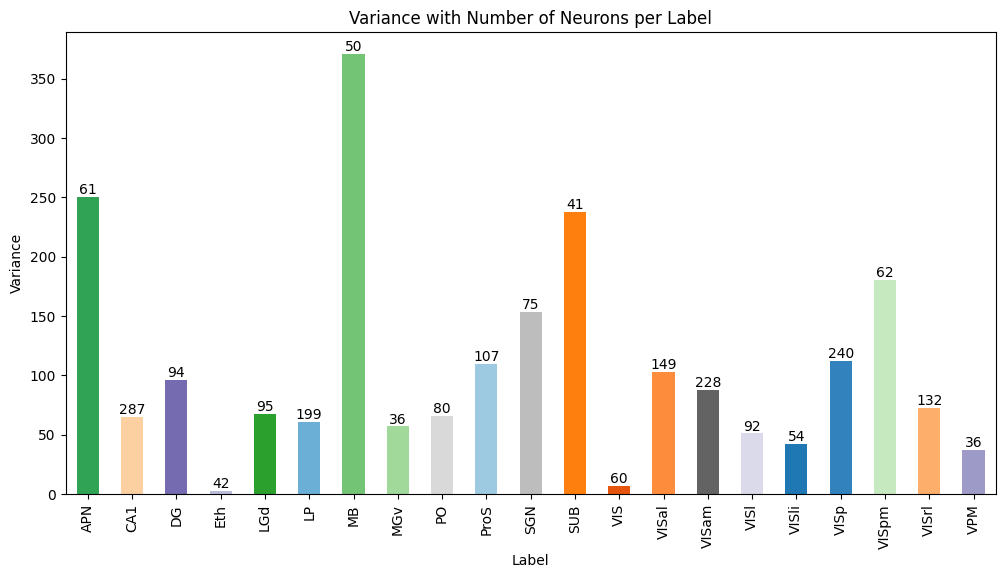

In [82]:
variance.plot(kind="bar", figsize=(12, 6),  color= neuron_c)

for i, v in enumerate(variance):
    plt.text(i, v + 0.1, str(Number_neurons[variance.index[i]]), ha='center', va='bottom')

plt.title('Variance with Number of Neurons per Label')
plt.xlabel('Label')
plt.ylabel('Variance')
plt.show()

We cannot really see any relevant correlation, so we move on with our analyzes.

## **3.5 - Multi Session Model**

### **3.5.1- Logistic Model with stratified sampling (unbiased)**

Here we removed underrepresented classes and employed stratified sampling to ensure a balanced data distribution for training and testing the model.

In [83]:
def shuffle(df, random_state):
    shuffled_df = df.sample(frac=1, random_state=random_state).reset_index(drop=True)
    return shuffled_df

def split_custom(df, column_name, random_state, test_size=0.2):

    unique_values = df[column_name].unique()
    datasets = {}
    for value in unique_values:
        datasets[value] = df[df[column_name] == value].copy()

    train_sets = {}
    test_sets = {}

    for value, data in datasets.items():
        train_sets[value], test_sets[value] = train_test_split(data, test_size=test_size, random_state=random_state)

    merged_train = pd.concat(train_sets.values())
    merged_test = pd.concat(test_sets.values())

    merged_train = shuffle(merged_train, random_state)
    merged_test = shuffle(merged_test, random_state)

    return merged_train, merged_test


In [84]:
train_dff , test_dff = split_custom(dff_lab, "label", 1553)

In [85]:
X_train, y_train = train_dff.iloc[:,1:], train_dff["label"]
X_test, y_test = test_dff.iloc[:,1:], test_dff["label"]

In [86]:
model_unb = LogisticRegression().fit(X_train, y_train)

y_train_pred = model_unb.predict(X_train)
y_test_pred = model_unb.predict(X_test)

In [87]:
print_accuracy(y_train, y_test, y_train_pred, y_test_pred)

Training Set Accuracy: 99.33270718431815%
Testing Set Accuracy: 45.226508418465066%


### **3.5.2 - Bootstrapping**

Bootstrapping helps assess how sensitive the model is to different subsets of the training data, indicating the stability and reliability of the model. By not using part of the data in each iteration for training, bootstrapping provides an unbiased estimate of model performance.

In [88]:
def bootstrap_classification(model, X_train, y_train, n_iterations=1000, test_size=0.33):
    scores = np.zeros(n_iterations)

    for i in range(n_iterations):
        X_sample, y_sample = resample(X_train, y_train, n_samples=int(len(X_train) * (1 - test_size)))

        model.fit(X_sample, y_sample)

        oob_sample = [x for x in range(len(X_train)) if x not in X_sample.index]
        y_pred = model.predict(X_train.iloc[oob_sample])

        scores[i] = accuracy_score(y_train.iloc[oob_sample], y_pred)

    return scores

In [89]:
bootstrap_scores = bootstrap_classification(model_unb, X_train, y_train, n_iterations=20)

print(f"Mean Accuracy: {bootstrap_scores.mean()}")
print(f"95% Confidence Interval: {np.percentile(bootstrap_scores, [2.5, 97.5])}")

Mean Accuracy: 0.3664357696586316
95% Confidence Interval: [0.3325641  0.39834068]


The narrow confidence interval around the low mean accuracy suggests that the model consistently performs poorly, with low variability in performance across samples.

### **3.5.3 - Logistic Model with tuned parameters (unbiased model)**

We proceed performing Grid Search to tune our parameters for the unbiased model.

In [90]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    "class_weight": ["balanced", None],
    "solver": ["lbfgs", "liblinear"],
    "multi_class": ["auto", "multinomial"]
}

balanced = make_scorer(balanced_accuracy_score)

grid_search = GridSearchCV(estimator=model_unb, param_grid=param_grid, cv=5, scoring=balanced, verbose=1)

In [91]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


/Users/emanuelemarinolibrandi/opt/anaconda3/envs/envallen/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:542: FitFailedWarning: 
200 fits failed out of a total of 400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/emanuelemarinolibrandi/opt/anaconda3/envs/envallen/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emanuelemarinolibrandi/opt/anaconda3/envs/envallen/lib/python3.11/site-packages/sklearn/base.py", line 1351, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'class_weight': ['balanced', None],
                         'multi_class': ['auto', 'multinomial'],
                         'penalty': ['l1', 'l2'],
                         'solver': ['lbfgs', 'liblinear']},
             scoring=make_scorer(balanced_accuracy_score, response_method='predict'),
             verbose=1)

In [92]:
print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy found: ", grid_search.best_score_)

best_model = grid_search.best_estimator_
#best_model = LogisticRegression(C=0.01, class_weight= 'balanced', multi_class= 'auto', penalty= 'l2', solver= 'liblinear').fit(X_train, y_train)
y_pred = best_model.predict(X_test)

print("Accuracy on test set: ", accuracy_score(y_test, y_pred))
print("\nClassification Report on test set:\n", classification_report(y_test, y_pred))

Best parameters found:  {'C': 0.01, 'class_weight': 'balanced', 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'lbfgs'}
Best accuracy found:  0.45227900674259847
Accuracy on test set:  0.46017699115044247

Classification Report on test set:
               precision    recall  f1-score   support

         APN       0.18      0.15      0.17        13
         CA1       0.48      0.55      0.52        58
          DG       0.39      0.37      0.38        19
         Eth       0.50      0.67      0.57         9
         LGd       0.53      0.47      0.50        19
          LP       0.50      0.47      0.49        40
          MB       0.42      0.50      0.45        10
         MGv       0.71      0.62      0.67         8
          PO       0.91      0.62      0.74        16
        ProS       0.50      0.45      0.48        22
         SGN       0.30      0.20      0.24        15
         SUB       0.56      0.56      0.56         9
         VIS       0.62      0.83      0.71        1

In [93]:
y_train_best = best_model.predict(X_train)
y_test_best = best_model.predict(X_test)

In [94]:
print_accuracy(y_train, y_test, y_train_best, y_test_best)

Training Set Accuracy: 98.72062029100074%
Testing Set Accuracy: 46.44644483491508%


We can see that our model improved.

In [95]:
bootstrap_scores_best = bootstrap_classification(best_model, X_train, y_train, n_iterations=10)

print(f"Mean Accuracy: {bootstrap_scores.mean()}")
print(f"95% Confidence Interval: {np.percentile(bootstrap_scores_best, [2.5, 97.5])}")

Mean Accuracy: 0.3664357696586316
95% Confidence Interval: [0.3746031  0.39955622]


### **3.5.4 - Static Gratings as stimuli**

We briefly explore the results of our model with *static gratings* as stimuli.

In [96]:
def get_table_g(number, session, stimuli = "static_gratings"):
    bins_dict = {}
    jumps = compute_jumps()
    start_time = [i for i in oursession.get_stimulus_table(stimuli).start_time]
    stop_time = [i for i in oursession.get_stimulus_table(stimuli).stop_time]

    for id in session.units.index.values:
        bins_dict[id] = [0 for i in range(number)]
        for spike in session.spike_times[id]:
            rounded_spike = math.floor(spike)
            if rounded_spike < number:
                bins_dict[id][rounded_spike] += 1

    data = pd.DataFrame(data=bins_dict).T
    for time in data.columns.values:
        if time <= math.floor(min(start_time)) or time >= math.floor(max(stop_time)):
            for id in session.units.index.values:
                data.loc[id, time] = 0

    for k in range(len(jumps)):
        for time in data.columns.values:
            if time >= math.floor(jumps[k][0]) and time <= math.floor(jumps[k][1]):
                for id in session.units.index.values:
                    data.loc[id, time] = 0
    return data

In [97]:
df_g = get_table(10000, oursession)
df_g

0     1     2     3     4     5     6     7     8     9     ...  \
951812724     0     0     0     0     0     0     0     0     0     0  ...   
951812745     0     0     0     0     0     0     0     0     0     0  ...   
951812785     0     0     0     0     0     0     0     0     0     0  ...   
951812765     0     0     0     0     0     0     0     0     0     0  ...   
951812811     0     0     0     0     0     0     0     0     0     0  ...   
...         ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
951804296     0     0     0     0     0     0     0     0     0     0  ...   
951804325     0     0     0     0     0     0     0     0     0     0  ...   
951804346     0     0     0     0     0     0     0     0     0     0  ...   
951804528     0     0     0     0     0     0     0     0     0     0  ...   
951804366     0     0     0     0     0     0     0     0     0     0  ...   

           9990  9991  9992  9993  9994  9995  9996  9997  9998  9999  
951812724     0     0     0     0     0     0     0     0     0     0  
951812745     0     0     0     0     0     0     0     0     0     0  
951812785     0     0     0     0     0     0     0     0     0     0  
951812765     0     0     0     0     0     0     0     0     0     0  
951812811     0     0     0     0     0     0     0     0     0     0  
...         ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  
951804296     0     0     0     0     0     0     0     0     0     0  
951804325     0     0     0     0     0     0     0     0     0     0  
951804346     0     0     0     0     0     0     0     0     0     0  
951804528     0     0     0     0     0     0     0     0     0     0  
951804366     0     0     0     0     0     0     0     0     0     0  

[959 rows x 10000 columns]

In [98]:
df_g.insert(0, "label", true_regions)
df_g_labels = df_g
df_g = df_g.drop('label', axis=1)

In [99]:
df_g_labels

label  0  1  2  3  4  5  6  7  8  ...  9990  9991  9992  9993  \
951812724    MRN  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
951812745    MRN  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
951812785    MRN  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
951812765    MRN  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
951812811    MRN  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
...          ... .. .. .. .. .. .. .. .. ..  ...   ...   ...   ...   ...   
951804296  VISrl  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
951804325  VISrl  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
951804346  VISrl  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
951804528  VISrl  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
951804366  VISrl  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   

           9994  9995  9996  9997  9998  9999  
951812724     0     0     0     0     0     0  
951812745     0     0     0     0     0     0  
951812785     0     0     0     0     0     0  
951812765     0     0     0     0     0     0  
951812811     0     0     0     0     0     0  
...         ...   ...   ...   ...   ...   ...  
951804296     0     0     0     0     0     0  
951804325     0     0     0     0     0     0  
951804346     0     0     0     0     0     0  
951804528     0     0     0     0     0     0  
951804366     0     0     0     0     0     0  

[959 rows x 10001 columns]

In [100]:
df_2_g = get_table_g(10000, session=oursession_2)
df_2_g

0     1     2     3     4     5     6     7     8     9     ...  \
951849410     0     0     0     0     0     0     0     0     0     0  ...   
951849423     0     0     0     0     0     0     0     0     0     0  ...   
951849448     0     0     0     0     0     0     0     0     0     0  ...   
951849441     0     0     0     0     0     0     0     0     0     0  ...   
951851905     0     0     0     0     0     0     0     0     0     0  ...   
...         ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
951853853     0     0     0     0     0     0     0     0     0     0  ...   
951853902     0     0     0     0     0     0     0     0     0     0  ...   
951853987     0     0     0     0     0     0     0     0     0     0  ...   
951854322     0     0     0     0     0     0     0     0     0     0  ...   
951854136     0     0     0     0     0     0     0     0     0     0  ...   

           9990  9991  9992  9993  9994  9995  9996  9997  9998  9999  
951849410     0     0     0     0     0     0     0     0     0     0  
951849423     0     0     0     0     0     0     0     0     0     0  
951849448     0     0     0     0     0     0     0     0     0     0  
951849441     0     0     0     0     0     0     0     0     0     0  
951851905     0     0     0     0     0     0     0     0     0     0  
...         ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  
951853853     0     0     0     0     0     0     0     0     0     0  
951853902     0     0     0     0     0     0     0     0     0     0  
951853987     0     0     0     0     0     0     0     0     0     0  
951854322     0     0     0     0     0     0     0     0     0     0  
951854136     0     0     0     0     0     0     0     0     0     0  

[650 rows x 10000 columns]

In [101]:
df_2_g.insert(0, "label", true_regions_2)
df_2_lab_g = df_2_g
df_2_g = df_2_g.drop('label', axis=1)

In [102]:
df_3_g = get_table_g(10000, oursession_3)
df_3_g

0     1     2     3     4     5     6     7     8     9     ...  \
951840133     0     0     0     0     0     0     0     0     0     0  ...   
951840145     0     0     0     0     0     0     0     0     0     0  ...   
951840143     0     0     0     0     0     0     0     0     0     0  ...   
951840147     0     0     0     0     0     0     0     0     0     0  ...   
951840152     0     0     0     0     0     0     0     0     0     0  ...   
...         ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
951840074     0     0     0     0     0     0     0     0     0     0  ...   
951839907     0     0     0     0     0     0     0     0     0     0  ...   
951839916     0     0     0     0     0     0     0     0     0     0  ...   
951839940     0     0     0     0     0     0     0     0     0     0  ...   
951840099     0     0     0     0     0     0     0     0     0     0  ...   

           9990  9991  9992  9993  9994  9995  9996  9997  9998  9999  
951840133     0     0     0     0     0     0     0     0     0     0  
951840145     0     0     0     0     0     0     0     0     0     0  
951840143     0     0     0     0     0     0     0     0     0     0  
951840147     0     0     0     0     0     0     0     0     0     0  
951840152     0     0     0     0     0     0     0     0     0     0  
...         ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  
951840074     0     0     0     0     0     0     0     0     0     0  
951839907     0     0     0     0     0     0     0     0     0     0  
951839916     0     0     0     0     0     0     0     0     0     0  
951839940     0     0     0     0     0     0     0     0     0     0  
951840099     0     0     0     0     0     0     0     0     0     0  

[773 rows x 10000 columns]

In [103]:
df_3_g.insert(0, "label", true_regions_3)
df_3_lab_g = df_3_g
df_3_g = df_3_g.drop('label', axis=1)

In [104]:
dff_g = pd.concat([df_g_labels, df_2_lab_g, df_3_lab_g], ignore_index=False)
#dff = dff.drop("label", axis=1)
#print(dff.shape)
for i in to_rem:
    dff_g= dff_g.drop(dff_g[dff_g["label"] == i].index)
print(dff_g.shape)

(2220, 10001)


In [105]:
dff_g

label  0  1  2  3  4  5  6  7  8  ...  9990  9991  9992  9993  \
951812829     MB  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
951812844     MB  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
951812877     MB  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
951815918    APN  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
951812907    APN  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
...          ... .. .. .. .. .. .. .. .. ..  ...   ...   ...   ...   ...   
951840074  VISrl  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
951839907  VISrl  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
951839916  VISrl  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
951839940  VISrl  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
951840099  VISrl  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   

           9994  9995  9996  9997  9998  9999  
951812829     0     0     0     0     0     0  
951812844     0     0     0     0     0     0  
951812877     0     0     0     0     0     0  
951815918     0     0     0     0     0     0  
951812907     0     0     0     0     0     0  
...         ...   ...   ...   ...   ...   ...  
951840074     0     0     0     0     0     0  
951839907     0     0     0     0     0     0  
951839916     0     0     0     0     0     0  
951839940     0     0     0     0     0     0  
951840099     0     0     0     0     0     0  

[2220 rows x 10001 columns]

In [106]:
dff_lab_g = dff_g
dff_g = dff_g.drop('label', axis=1)

In [107]:
dff_labels_g = [i for i in dff_lab_g.label]

In [108]:
train_dff_g , test_dff_g = split_custom(dff_lab_g, "label", 1553)

In [109]:
X_train_g, y_train_g = train_dff_g.iloc[:,1:], train_dff_g["label"]
X_test_g, y_test_g = test_dff_g.iloc[:,1:], test_dff_g["label"]

In [110]:
model_unb_g = LogisticRegression().fit(X_train_g, y_train_g)

y_train_pred_g = model_unb_g.predict(X_train_g)
y_test_pred_g = model_unb_g.predict(X_test_g)

In [111]:
print_accuracy(y_train_g, y_test_g, y_train_pred_g, y_test_pred_g)

Training Set Accuracy: 99.6815866084425%
Testing Set Accuracy: 44.39360994188843%


This model yielded approximatively the same results as the one considering on natural scenes.

In [112]:
param_grid_g = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    "class_weight": ["balanced", None],
    "solver": ["lbfgs", "liblinear"],
    "multi_class": ["auto", "multinomial"]
}
grid_search_g = GridSearchCV(estimator=model_unb_g, param_grid=param_grid_g, cv=5, scoring='accuracy', verbose=1)

In [113]:
grid_search_g.fit(X_train_g, y_train_g)
print("Best parameters found gratings: ", grid_search_g.best_params_)
print("Best accuracy found gratings: ", grid_search_g.best_score_)

best_model_g = grid_search_g.best_estimator_

Fitting 5 folds for each of 80 candidates, totalling 400 fits


/Users/emanuelemarinolibrandi/opt/anaconda3/envs/envallen/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:542: FitFailedWarning: 
200 fits failed out of a total of 400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/emanuelemarinolibrandi/opt/anaconda3/envs/envallen/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emanuelemarinolibrandi/opt/anaconda3/envs/envallen/lib/python3.11/site-packages/sklearn/base.py", line 1351, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^

Best parameters found gratings:  {'C': 0.01, 'class_weight': None, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'lbfgs'}
Best accuracy found gratings:  0.4722859749363807


In [114]:
best_model_g = LogisticRegression(C= 0.001, class_weight= "balanced", multi_class= 'auto', penalty= 'l2', solver= 'liblinear').fit(X_train_g, y_train_g)

y_test_pred_g = best_model_g.predict(X_test_g)
y_train_pred_g = best_model_g.predict(X_train_g)

print_accuracy(y_train_g, y_test_g, y_train_pred_g, y_test_pred_g)

Training Set Accuracy: 97.79352786463575%
Testing Set Accuracy: 47.7986950500365%


Changing the stimuli to static gratins we obtain approximately the same results. Our model is consistent across stimuli kinds.

### **3.5.5- Performance measures Natural Scenes Log regression**

In [115]:
print("Mean cross validated score:", cross_val_score(best_model, X_train, y_train).mean())

Mean cross validated score: 0.4377794849634289


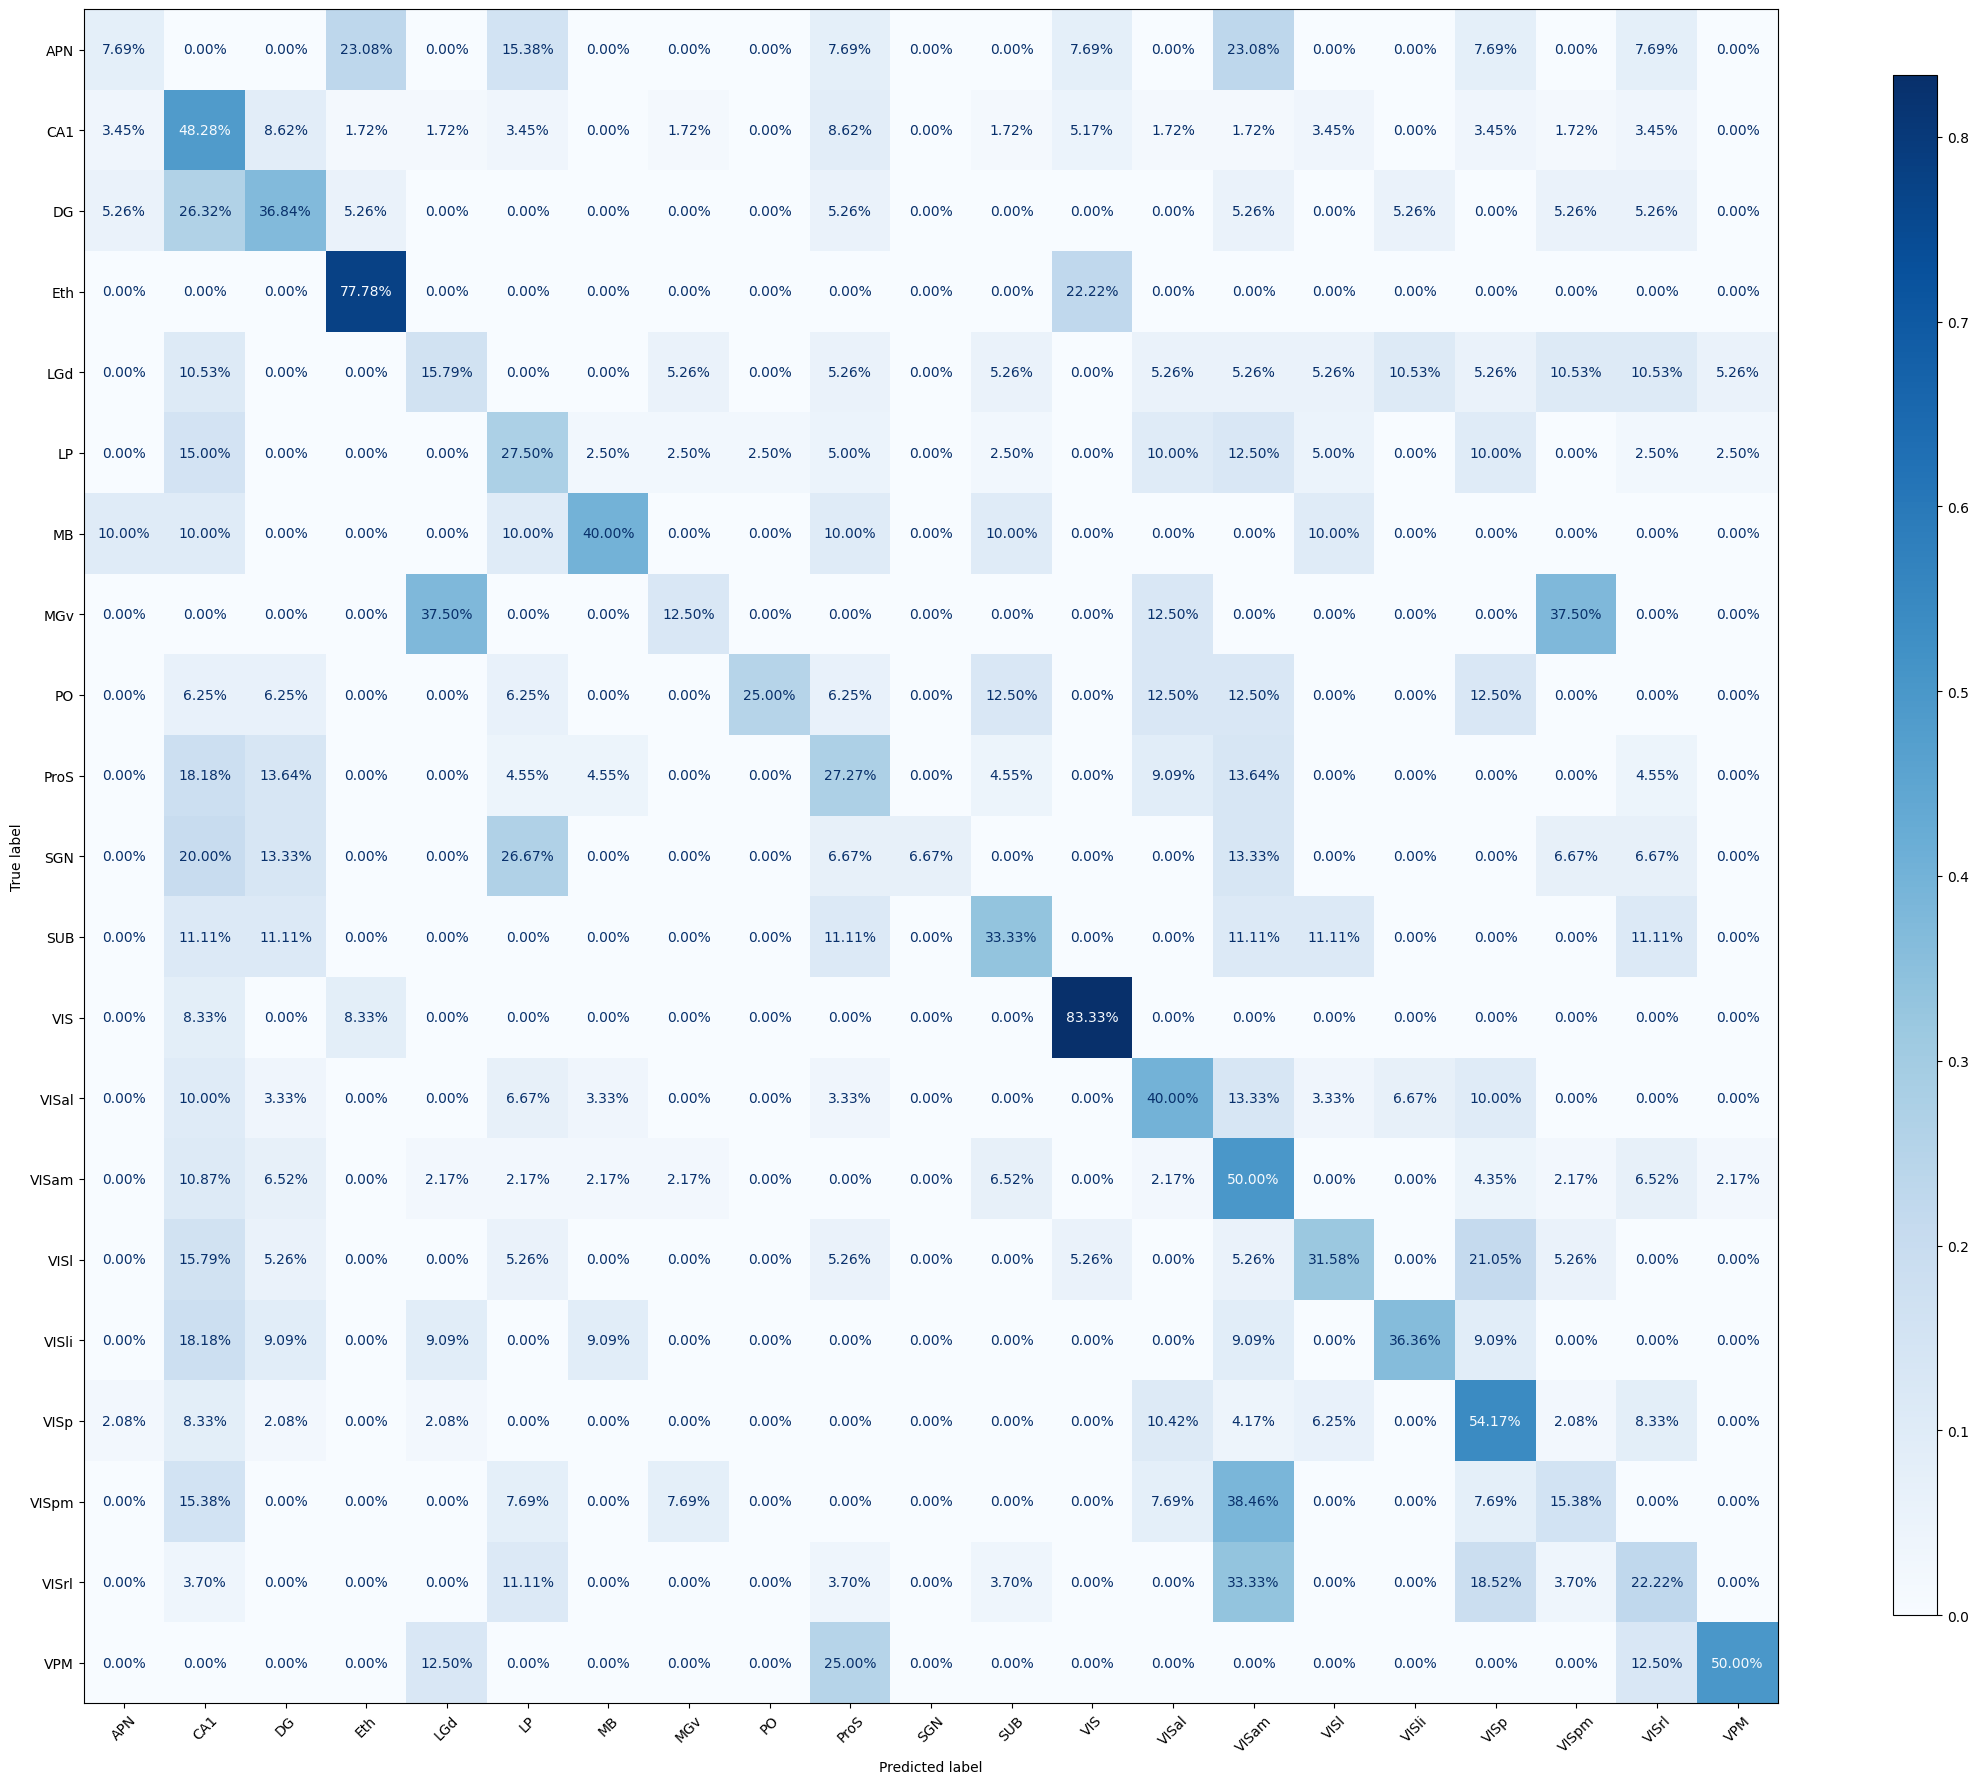

In [116]:
conf_matrix(best_model, X_test, y_test, normalize=True)

In [117]:
def print_performance(predictions, y_train, average=None):
    print("Precision score (with macro averaging):", str(precision_score(y_train, predictions, average=average)*100)+"%")
    print("Recall score (with macro averaging):", str(recall_score(y_train, predictions, average=average)*100)+"%")
    print("F1 score (with macro averaging):", str(f1_score(y_train, predictions, average=average)*100)+"%")

In [118]:
def ROC_curves(model, X_test, y_train, y_test):
    y_prob = model.predict_proba(X_test)
    label_binarizer = LabelBinarizer().fit(y_train)
    y_onehot_test = label_binarizer.transform(y_test)

    fig, axs = plt.subplots(label_binarizer.classes_.shape[0], 1, figsize=(7, 7 * label_binarizer.classes_.shape[0]))

    for i, class_id in enumerate(label_binarizer.classes_):
        roc_display = RocCurveDisplay.from_predictions(
            y_onehot_test[:, i],
            y_prob[:, i],
            name=f"{class_id} vs the rest",
            color="dodgerblue",
            ax=axs[i]  
        )

        axs[i].plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
        axs[i].axis("square")
        axs[i].set_xlabel("False Positive Rate")
        axs[i].set_ylabel("True Positive Rate")
        axs[i].legend()
        axs[i].set_title(f"Label {class_id} vs the rest")

    plt.tight_layout()  
    plt.legend()
    plt.show()

In [119]:
print_performance(y_train_best, y_train, "macro")

Precision score (with macro averaging): 97.45810310796644%
Recall score (with macro averaging): 98.72062029100074%
F1 score (with macro averaging): 98.00676728322402%


In [120]:
print_performance(y_test_best, y_test, "macro")

Precision score (with macro averaging): 48.65110163639576%
Recall score (with macro averaging): 46.44644483491508%
F1 score (with macro averaging): 46.96533521164972%


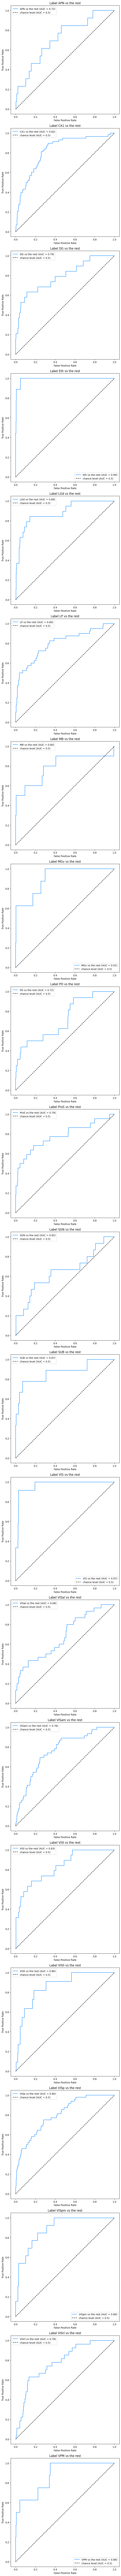

In [121]:
ROC_curves(best_model, X_test, y_train, y_test)

### **3.5.6- Performance measures Static Gratings Log regression**

In [122]:
print("Mean cross validated score:", cross_val_score(best_model_g, X_train_g, y_train_g).mean())

Mean cross validated score: 0.48811958835485986


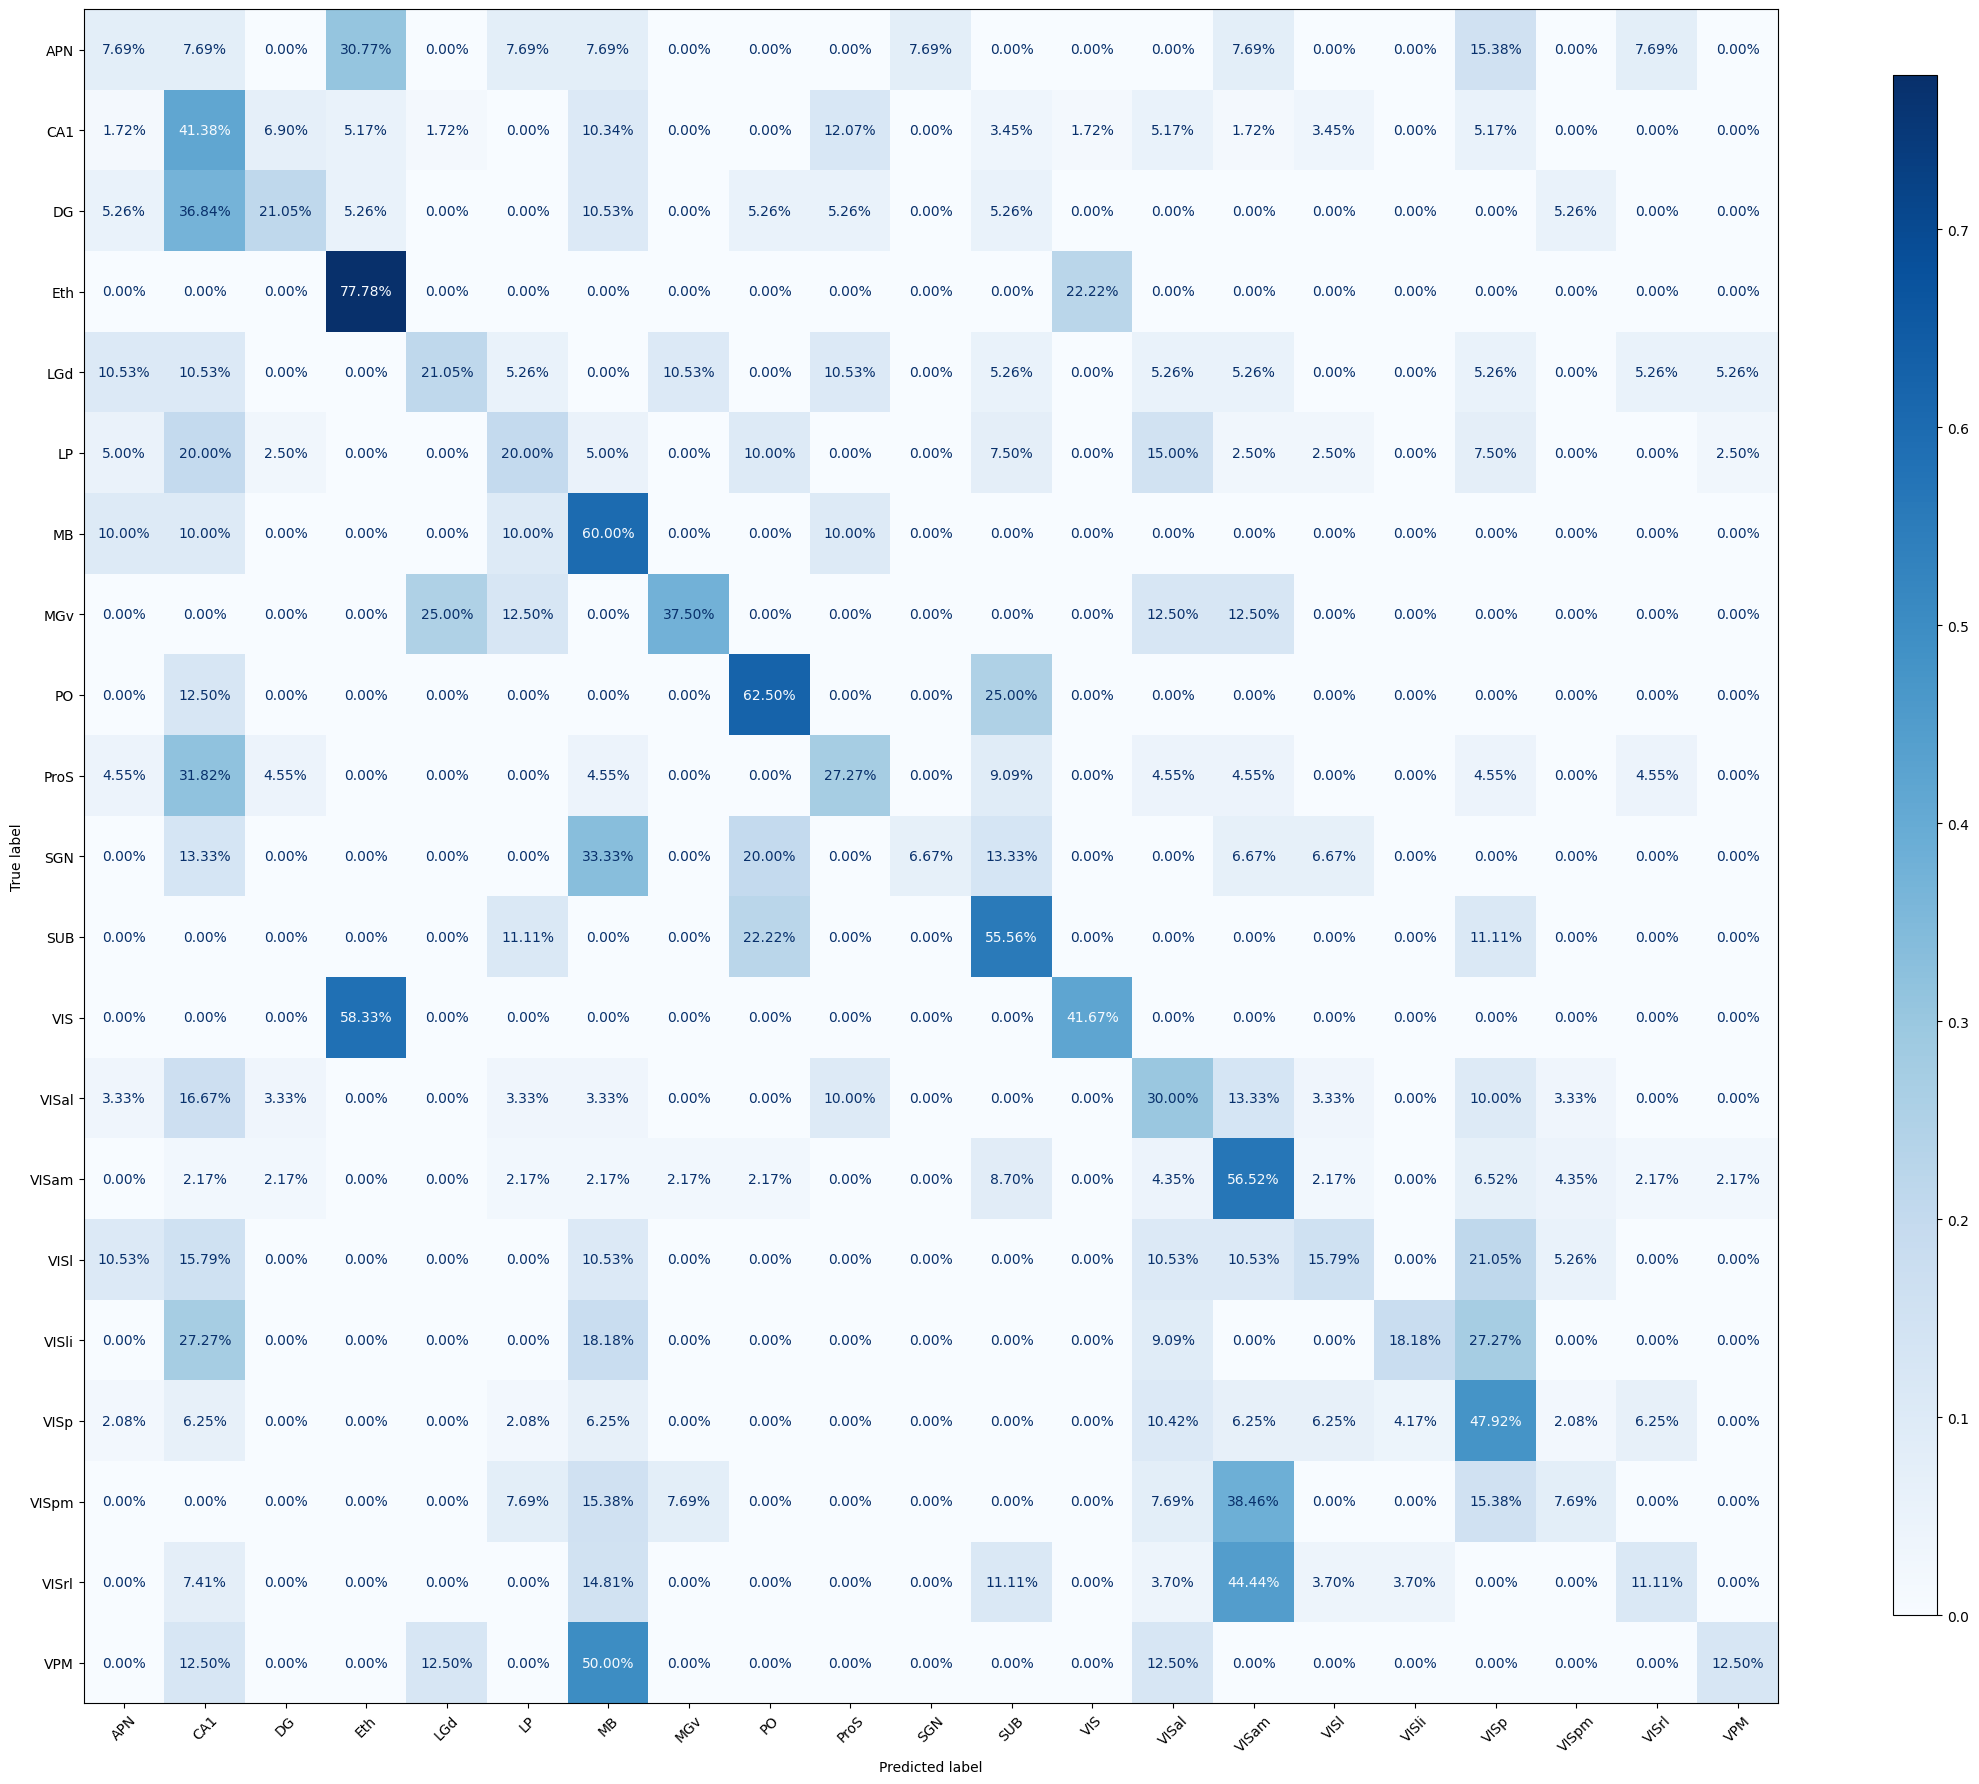

In [123]:
conf_matrix(best_model_g, X_test_g, y_test_g, normalize=True)

In [124]:
print_performance(y_train_pred_g, y_train_g, "macro")

Precision score (with macro averaging): 96.4312323851681%
Recall score (with macro averaging): 97.79352786463575%
F1 score (with macro averaging): 96.96273129521794%


In [125]:
print_performance(y_test_pred_g, y_test_g, "macro")

Precision score (with macro averaging): 52.09875498640497%
Recall score (with macro averaging): 47.7986950500365%
F1 score (with macro averaging): 47.80438573591992%


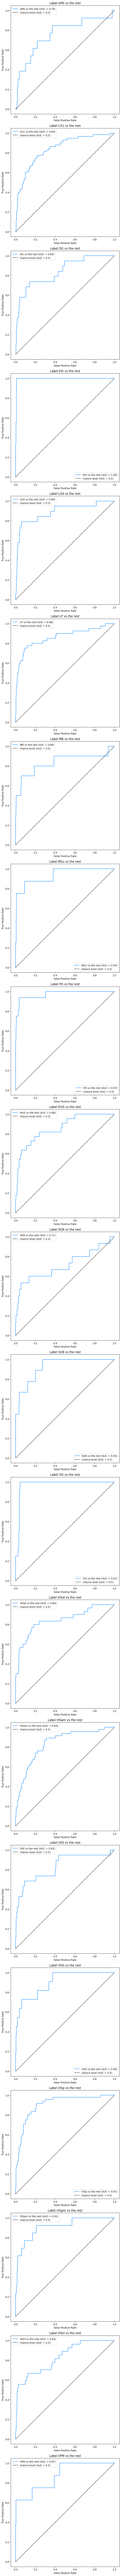

In [126]:
ROC_curves(best_model_g, X_test_g, y_train_g, y_test_g)

The logistic regression model on static gratings performes sligthly better than the one on natural scenes. However, we decide to keep the model with natural scenes as stimuli in the following analysis as this type of stimuli is more experimentally relevant.

### **3.5.7 - Accuracy (balanced) as a function of the number of neurons**

Now we want to understand how the accuracy of our classifier changes as a function of the number of neurons in our dataset. We will start from approximatively 50 neurons up to 2000.

In [127]:
def remove_(data):
    data_dict = data[data.columns[0]].value_counts().to_dict()
    to_remove = areas_to_remove(data_dict, 5)
    for i in to_remove:
        data = data.drop(data[data['label'] == i].index)
    return data

In [128]:
def iterate_logistic_regression(data_labels, max_size, seeds):
    training_scores = []
    testing_scores = []
    dataset_sizes = []

    data_labels = shuffle(data_labels, random_state=5231)

    data = data_labels.iloc[:, 1:]
    labels = data_labels.iloc[:, 0]

    for size in range(100, max_size, 50):
        subset_data = data[:size]
        subset_labels = labels[:size]

        dataset_sizes.append(size)

        subset_data, subset_labels = remove_classes(subset_data, subset_labels)

        train_scores = []
        test_scores = []

        for seed in seeds:
            X_train, X_test, y_train, y_test = train_test_split(subset_data, subset_labels, stratify=subset_labels, test_size=0.2, random_state=seed)

            model = LogisticRegression()
            model.fit(X_train, y_train)

            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)

            train_scores.append(balanced_accuracy_score(y_train, y_train_pred))
            test_scores.append(balanced_accuracy_score(y_test, y_test_pred))

        training_scores.append(np.mean(train_scores))
        testing_scores.append(np.mean(test_scores))

    return dataset_sizes, training_scores, testing_scores

def remove_classes(data, labels, min_observation=4):
    class_counts = labels.value_counts()
    classes_to_remove = class_counts[class_counts < min_observation].index
    mask = labels.isin(classes_to_remove)
    return data[~mask], labels[~mask]


In [129]:
def iterate_logistic_regression2(data_labels, max_size, seed):
    mean_cv_score = []
    std_cv_score = []
    dataset_sizes = []

    data_labels = shuffle(data_labels, random_state=5231)

    data = data_labels.iloc[:, 1:]
    labels = data_labels.iloc[:, 0]

    for size in range(100, max_size, 50):
        subset_data = data[:size]
        subset_labels = labels[:size]

        dataset_sizes.append(size)

        subset_data, subset_labels = remove_classes(subset_data, subset_labels)

        train_scores = []
        test_scores = []

        X_train, X_test, y_train, y_test = train_test_split(subset_data, subset_labels, stratify=subset_labels, test_size=0.2, random_state=seed)

        model = LogisticRegression()

        kfold = KFold(n_splits=5, shuffle=True, random_state=seed*4)

        cv_scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')

        mean_cv_score.append(cv_scores.mean())
        std_cv_score.append(cv_scores.std())

    return dataset_sizes, mean_cv_score, std_cv_score

In [130]:
number_neurons, train_err, test_err = iterate_logistic_regression(dff_lab, 2000, [8, 352, 46, 3445])

Text(0, 0.5, 'Train set accuracy')

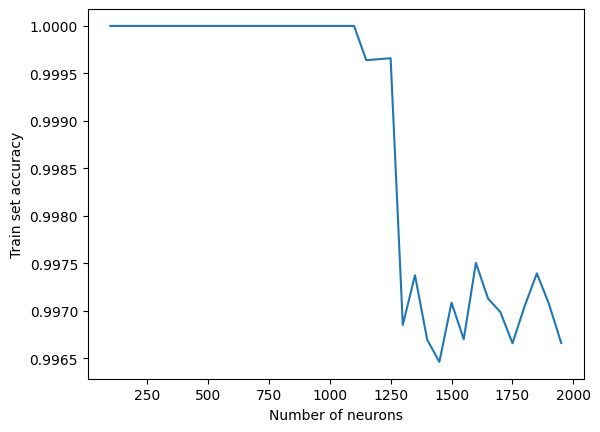

In [131]:
fig, ax = plt.subplots()
ax.plot(number_neurons, train_err)
ax.set_xlabel("Number of neurons")
ax.set_ylabel("Train set accuracy")

Text(0, 0.5, 'Test set accuracy')

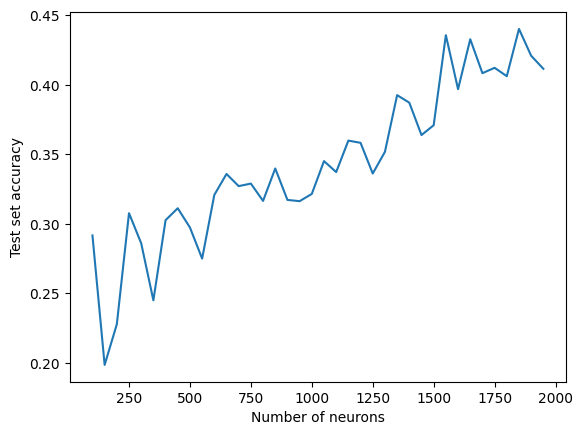

In [132]:
fig, ax = plt.subplots()
ax.plot(number_neurons, test_err)
ax.set_xlabel("Number of neurons")
ax.set_ylabel("Test set accuracy")

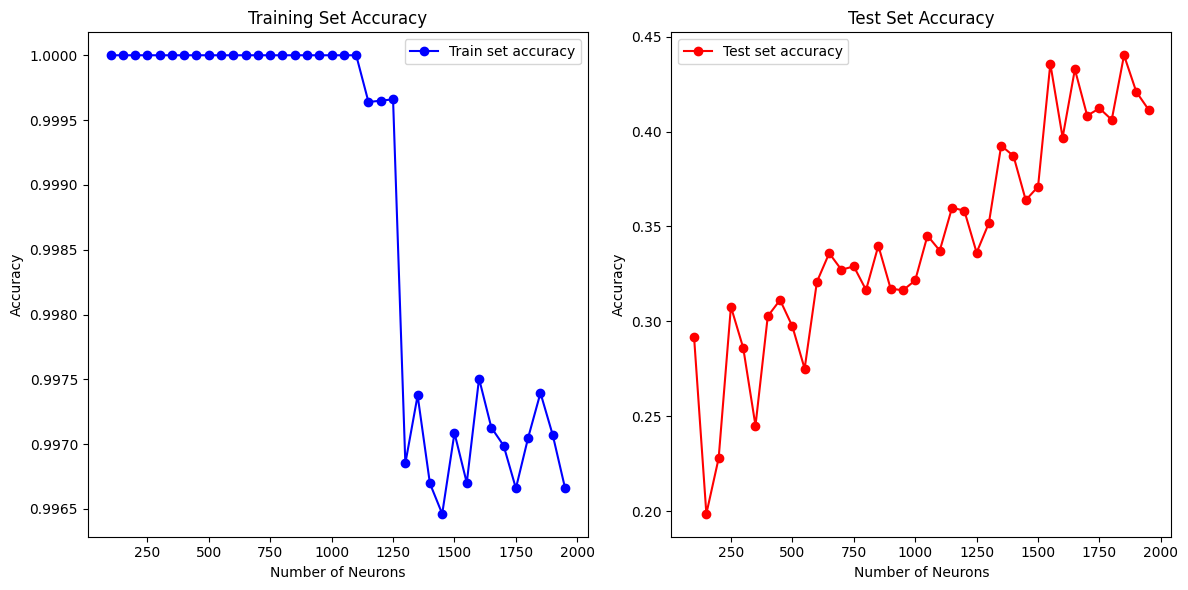

In [133]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].plot(number_neurons, train_err, color='blue', marker='o', label='Train set accuracy')
axes[0].set_title('Training Set Accuracy')
axes[0].set_xlabel('Number of Neurons')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(number_neurons, test_err, color='red', marker='o', label='Test set accuracy')
axes[1].set_title('Test Set Accuracy')
axes[1].set_xlabel('Number of Neurons')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

In [134]:
number_neurons, cross_mean, cross_std = iterate_logistic_regression2(dff_lab, 2000, 8)

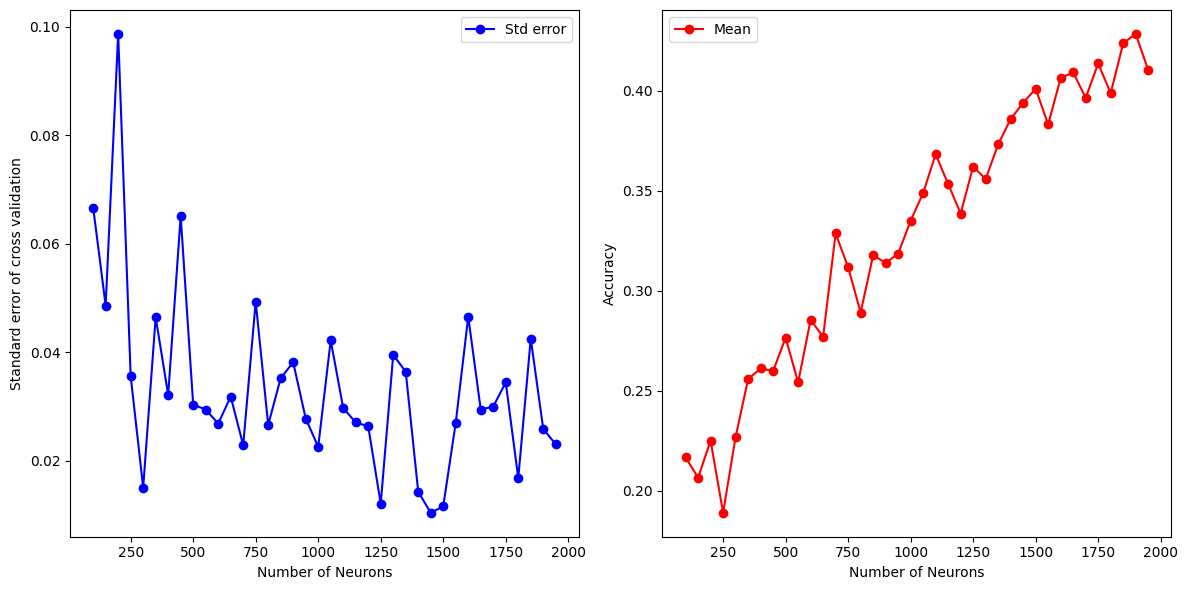

In [167]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].plot(number_neurons, cross_std, color='blue', marker='o', label='Std error')
axes[0].set_xlabel('Number of Neurons')
axes[0].set_ylabel('Standard error of cross validation')
axes[0].legend()

axes[1].plot(number_neurons, cross_mean, color='red', marker='o', label='Mean')
axes[1].set_xlabel('Number of Neurons')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

The results illustrate the impact of increasing the number of neurons on model performance:

A slight decrease in training accuracy implies a modest reduction in overfitting.
An increase in test accuracy confirms that the model is effectively classifying a greater proportion of neurons correctly, improving its predictive capability.
The reduction in the standard error of the cross-validation scores indicates more reliable model performance.
The increase in the mean value of cross-validation scores serves as a strong indicator that expanding the dataset is beneficial. This leads to a more robust and accurate classifier.

### **3.5.7 - Comparing to the results of a dummy classifier (as a function of neurons)**

We now compare our model to a random one to check its robustness.

In [136]:
def random(X, y, n_iterations):
    ran_accuracies = []

    for i in range(n_iterations):
        dummy_clf = DummyClassifier(strategy='stratified')
        dummy_clf.fit(X, y)
        y_ran_pred = dummy_clf.predict(X)
      
        ran_accuracy = accuracy_score(y, y_ran_pred)
        ran_accuracies.append(ran_accuracy)
        
    mean_ran_accuracy = np.mean(ran_accuracies)*100
    conf_ran = np.percentile(ran_accuracies, [2.5, 97.5])*100

    return mean_ran_accuracy, conf_ran

random_res = random(X_test, y_test, 1000)
print(f"Random Model Mean Accuracy: {random_res[0]}")
print(f"Random Model 95% Confidence Interval: {random_res[1]}")

Random Model Mean Accuracy: 6.888938053097346
Random Model 95% Confidence Interval: [4.6460177 9.2920354]


In [137]:
def iterate_random(data_labels, max_size, seed):
    mean_accuracy = []
    dataset_sizes = []

    data_labels = shuffle(data_labels, random_state=5231)

    data = data_labels.iloc[:, 1:]
    labels = data_labels.iloc[:, 0]

    for size in range(100, max_size, 50):
        subset_data = data[:size]
        subset_labels = labels[:size]

        dataset_sizes.append(size)

        subset_data, subset_labels = remove_classes(subset_data, subset_labels)

        X_train, X_test, y_train, y_test = train_test_split(subset_data, subset_labels, stratify=subset_labels, test_size=0.2, random_state=seed)

        random_res = random(X_test, y_test, size)

        mean_accuracy.append(random_res[0]/100)

    return dataset_sizes, mean_accuracy

In [138]:
NN, random_accuracy = iterate_random(dff_lab, 2000, 8)

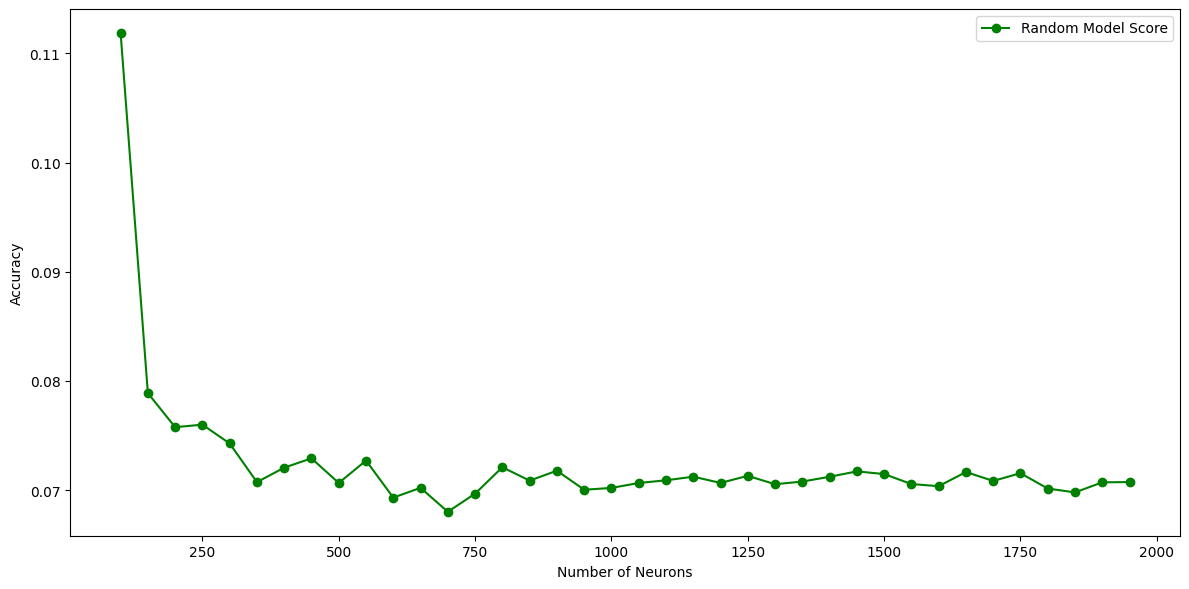

In [139]:
fig, axes = plt.subplots(1, figsize=(12, 6))

axes.plot(NN, random_accuracy, color='green', marker='o', label='Random Model Score')
axes.set_xlabel('Number of Neurons')
axes.set_ylabel('Accuracy')
axes.legend()

plt.tight_layout()
plt.show()

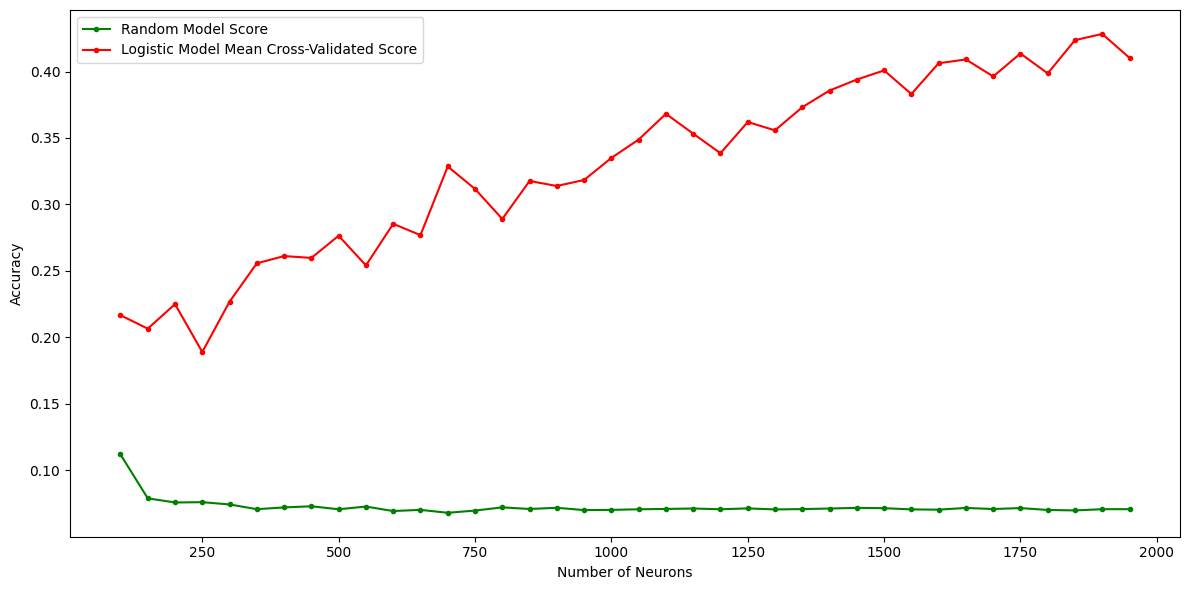

In [140]:
fig, axes = plt.subplots(1, figsize=(12, 6))

axes.plot(NN, random_accuracy, color='green', marker='.', label='Random Model Score')
axes.set_xlabel('Number of Neurons')
axes.legend()

axes.plot(NN, cross_mean, color='red', marker='.', label='Logistic Model Mean Cross-Validated Score')
axes.set_ylabel('Accuracy')
axes.legend()

plt.tight_layout()
plt.show()

Since the average accuracy of this baseline model is around 7%, we deduce that our model learns meaningful patterns beyond random chance and checks for robustness. 

### **3.5.8 - Analyzing the weights of the logistic regression**

In [141]:
def print_balanced_accuracy(y_train, y_test, y_train_pred, y_test_pred):
    balanced_acc_train = balanced_accuracy_score(y_train, y_train_pred)
    balanced_acc_test = balanced_accuracy_score(y_test, y_test_pred)

    print(f"Balanced Accuracy Train: {balanced_acc_train*100}%")
    print(f"Balanced Accuracy Test: {balanced_acc_test*100}%")

In [142]:
X_train, X_test, y_train, y_test = train_test_split(dff_lab.iloc[:,1:], dff_lab["label"], stratify=dff_lab["label"], test_size=0.2, random_state=23)

In [143]:
model = LogisticRegression(C=0.01, class_weight='balanced', solver='liblinear').fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print_balanced_accuracy(y_train, y_test, y_train_pred, y_test_pred)

Balanced Accuracy Train: 99.46091604343601%
Balanced Accuracy Test: 44.561357606470395%


In [144]:
coefficients = pd.DataFrame(model.coef_)

In [145]:
coefficients = model.coef_
time_bin_importance_df = pd.DataFrame(data=coefficients, columns=dff.columns)
sorted_time_bin_importance_df = time_bin_importance_df.apply(lambda x: np.abs(x)).mean().sort_values(ascending=False)
not_sort_time_bin_importance_df = time_bin_importance_df.apply(lambda x: np.abs(x)).mean()

print(sorted_time_bin_importance_df)

5912    0.050339
5913    0.046409
6003    0.045511
5993    0.043316
5932    0.042516
          ...   
3333    0.000000
3334    0.000000
3335    0.000000
3336    0.000000
9999    0.000000
Length: 10000, dtype: float64


In [146]:
sorted_time_bin_importance_df = sorted_time_bin_importance_df[sorted_time_bin_importance_df>0]
not_sort_time_bin_importance_df = not_sort_time_bin_importance_df[not_sort_time_bin_importance_df>0]

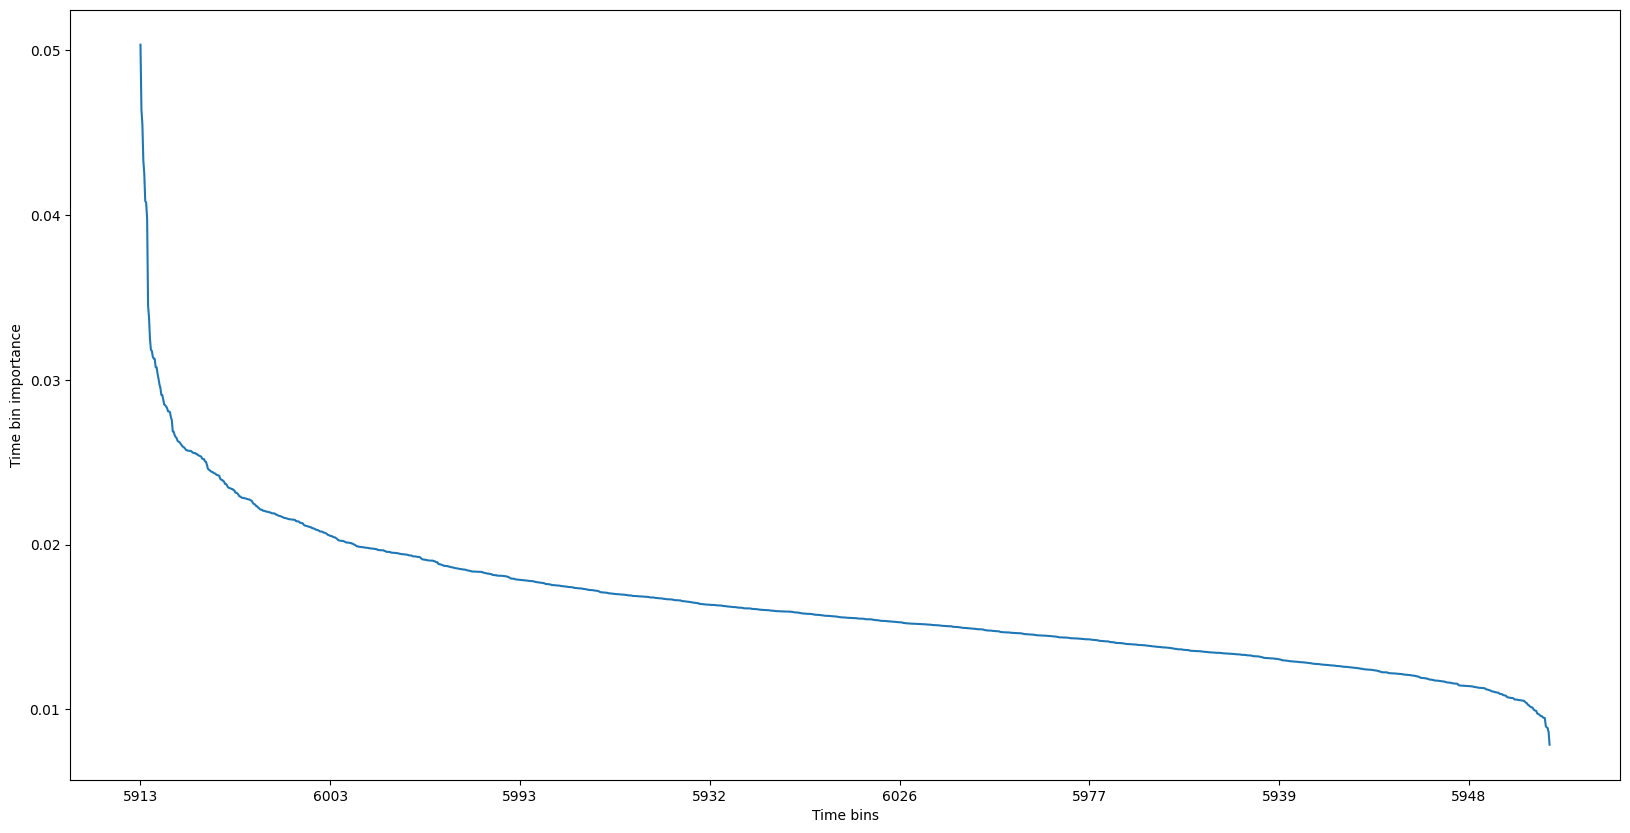

In [147]:
fig, ax = plt.subplots(figsize=(20, 10))  

ax.plot(range(len(sorted_time_bin_importance_df)), sorted_time_bin_importance_df.values)

ax.set_xlabel("Time bins")
ax.set_ylabel("Time bin importance")

ax.set_xticklabels(sorted_time_bin_importance_df.index)
# ax.set_xticks(range(len(sorted_time_bin_importance_df)))
# ax.set_xticklabels(sorted_time_bin_importance_df.index, rotation=90, fontsize=6)  # Adjust rotation and fontsize as needed

plt.show()

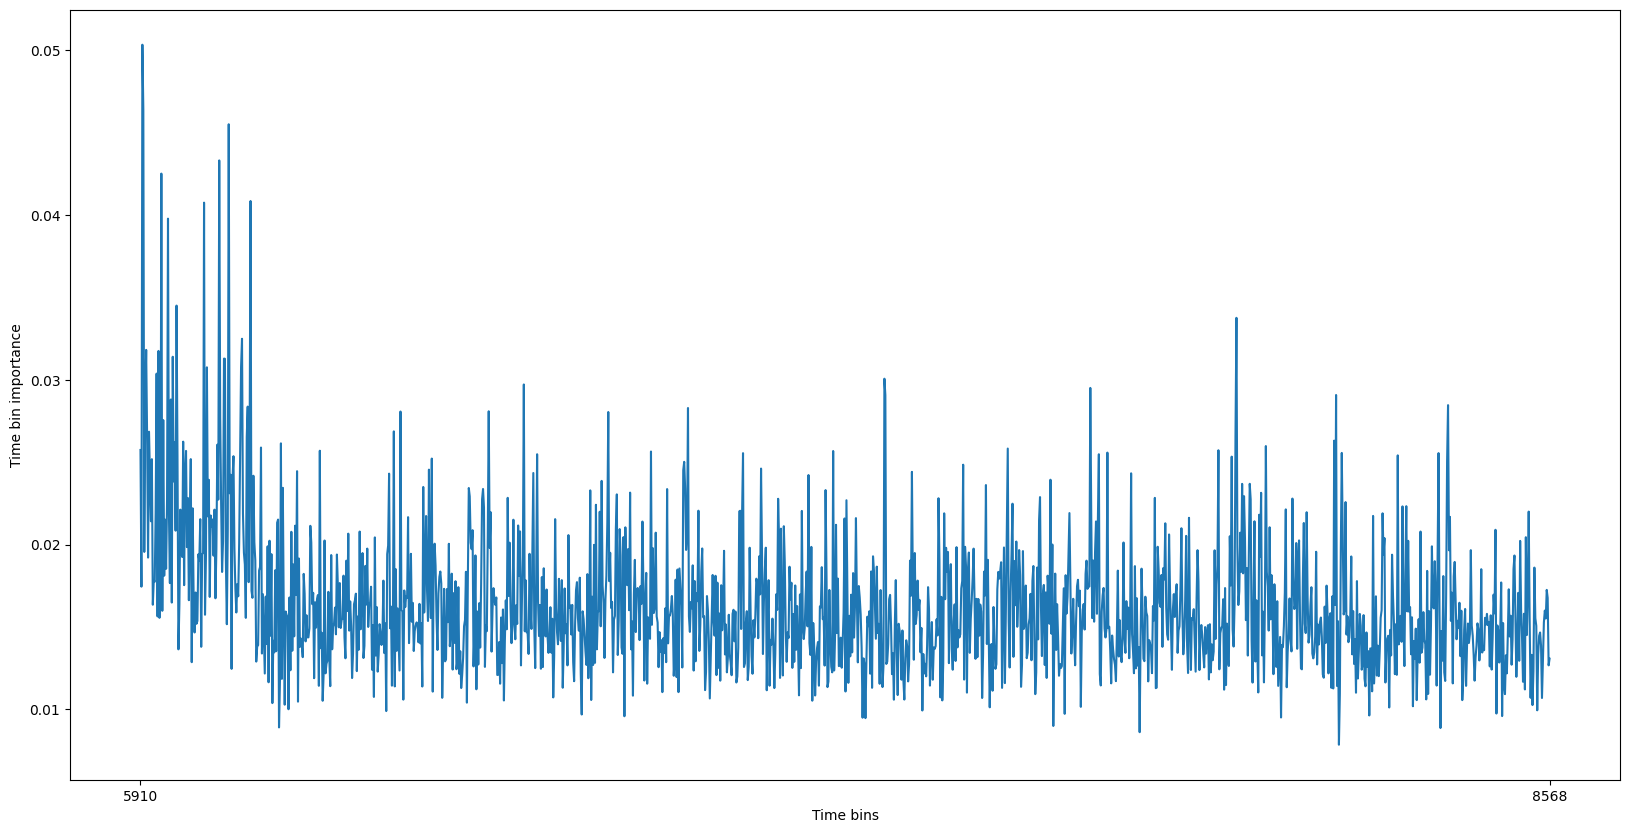

In [148]:
fig, ax = plt.subplots(figsize=(20, 10))

ax.plot(range(len(not_sort_time_bin_importance_df)), not_sort_time_bin_importance_df.values)

ax.set_xlabel("Time bins")
ax.set_ylabel("Time bin importance")

ax.set_xticks([0, len(not_sort_time_bin_importance_df)-1])
ax.set_xticklabels([not_sort_time_bin_importance_df.index[0], not_sort_time_bin_importance_df.index[-1]])

plt.show()


In [149]:
def plot_importance(data):
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.plot(range(len(data)), data.values)

    ax.set_xlabel("Time bins")
    ax.set_ylabel("Time bin importance")

    ax.set_xticks([0, len(data)-1])
    ax.set_xticklabels([data.index[0], data.index[-1]])

    plt.show()


In [150]:
start_index = 5900
end_index = 8600
index_values = not_sort_time_bin_importance_df.index

filtered = not_sort_time_bin_importance_df[(index_values >= start_index) & (index_values <= end_index)]
print(filtered)

5910    0.025738
5911    0.017442
5912    0.050339
5913    0.046409
5914    0.019551
          ...   
8564    0.015510
8565    0.017246
8566    0.016758
8567    0.012667
8568    0.013071
Length: 1486, dtype: float64


We trying to understand what the importance of a time bin reprented, and why the importance fluctuates this much. However, as it was not aligned with our main research question, we decided to not delve deeper into this analysis. One of our hypothesis was that the first time bins are the ones more relevant to the classifier as the mice are seeing the images for the first time, and so the firing rate should be more intense/have high variance/carry more information: that's why there are peaks of higher importance and the mean importance is higher during the first times mice see natural scenes images. We did not try to prove this idea.

### **3.5.9 - Logistic Model removing zero columns**

We aimed to enhance our model's performance by decreasing sparsity, and to that end, we eliminated the columns with zero entries from the dataframe.

In [152]:
dff_lab_no_zeros = dff_lab.loc[:, (dff_lab != 0).any(axis=0)]
dff_lab_no_zeros

label  5910  5911  5912  5913  5914  5915  5916  5917  5918  ...  \
951812829     MB     0     0     1     0     0     0     0     0     0  ...   
951812844     MB     0     0     1     0     0     0     0     0     0  ...   
951812877     MB    26    27    11    33    35    35    32    33    35  ...   
951815918    APN     2     0     4     2     0     0     0     0     0  ...   
951812907    APN     1     0     0     0     0     0     0     0     0  ...   
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
951840074  VISrl     1     0     0     0     0     2     0     1     1  ...   
951839907  VISrl     3     2     6     3     3    12     1     2     1  ...   
951839916  VISrl     1     0     6     5     4     2     0     8     0  ...   
951839940  VISrl    17     9    12    12    11     9    16    12     7  ...   
951840099  VISrl     2     6    13    11     1    10    10    13     3  ...   

           8559  8560  8561  8562  8563  8564  8565  8566  8567  8568  
951812829     4     3     2     2     4     6     4     5     2     3  
951812844     0     0     0     0     3     9     0     3     1     0  
951812877     0    12    12     6     0     1     1    15     7     2  
951815918     0     1     0     0     6     0     0     0     0     0  
951812907     0     0     0     0     0     0     0     0     0     0  
...         ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  
951840074     0     0     0     0     0     0     0     0     0     0  
951839907     4     6     0     6    17     8     3     6     0     3  
951839916     5     2     4     6     1     2     6     0     0     0  
951839940     6     4    19    11     5     2     8     8     5     7  
951840099     0     1     0     0     0     2     1     2     3     2  

[2220 rows x 1487 columns]

In [153]:
train_dff_0, test_dff_0 = split_custom(dff_lab_no_zeros, "label", 1553)

X_train_0, y_train_0 = train_dff_0.drop('label', axis=1), train_dff_0['label']
X_test_0, y_test_0 = test_dff_0.drop('label', axis=1), test_dff_0['label']

model_0 = LogisticRegression().fit(X_train_0, y_train_0)

y_train_pred_0 = model_0.predict(X_train_0)
y_test_pred_0 = model_0.predict(X_test_0)

print_accuracy(y_train_0, y_test_0, y_train_pred_0, y_test_pred_0)

Training Set Accuracy: 99.33270718431815%
Testing Set Accuracy: 45.226508418465066%


This adjustment yielded a modest improvement in accuracy by a few percentage points, yet the model is still overfitting (test accuracy that remains around 99%).

In [154]:
best_model_0 = LogisticRegression(C=0.01, class_weight= 'balanced', multi_class= 'auto', penalty= 'l2', solver= 'lbfgs').fit(X_train_0, y_train_0)

In [155]:
y_train_best_0 = best_model_0.predict(X_train_0)
y_test_best_0 = best_model_0.predict(X_test_0)
print_accuracy(y_train_0, y_test_0, y_train_best_0, y_test_best_0)

Training Set Accuracy: 98.72062029100074%
Testing Set Accuracy: 46.44644483491508%


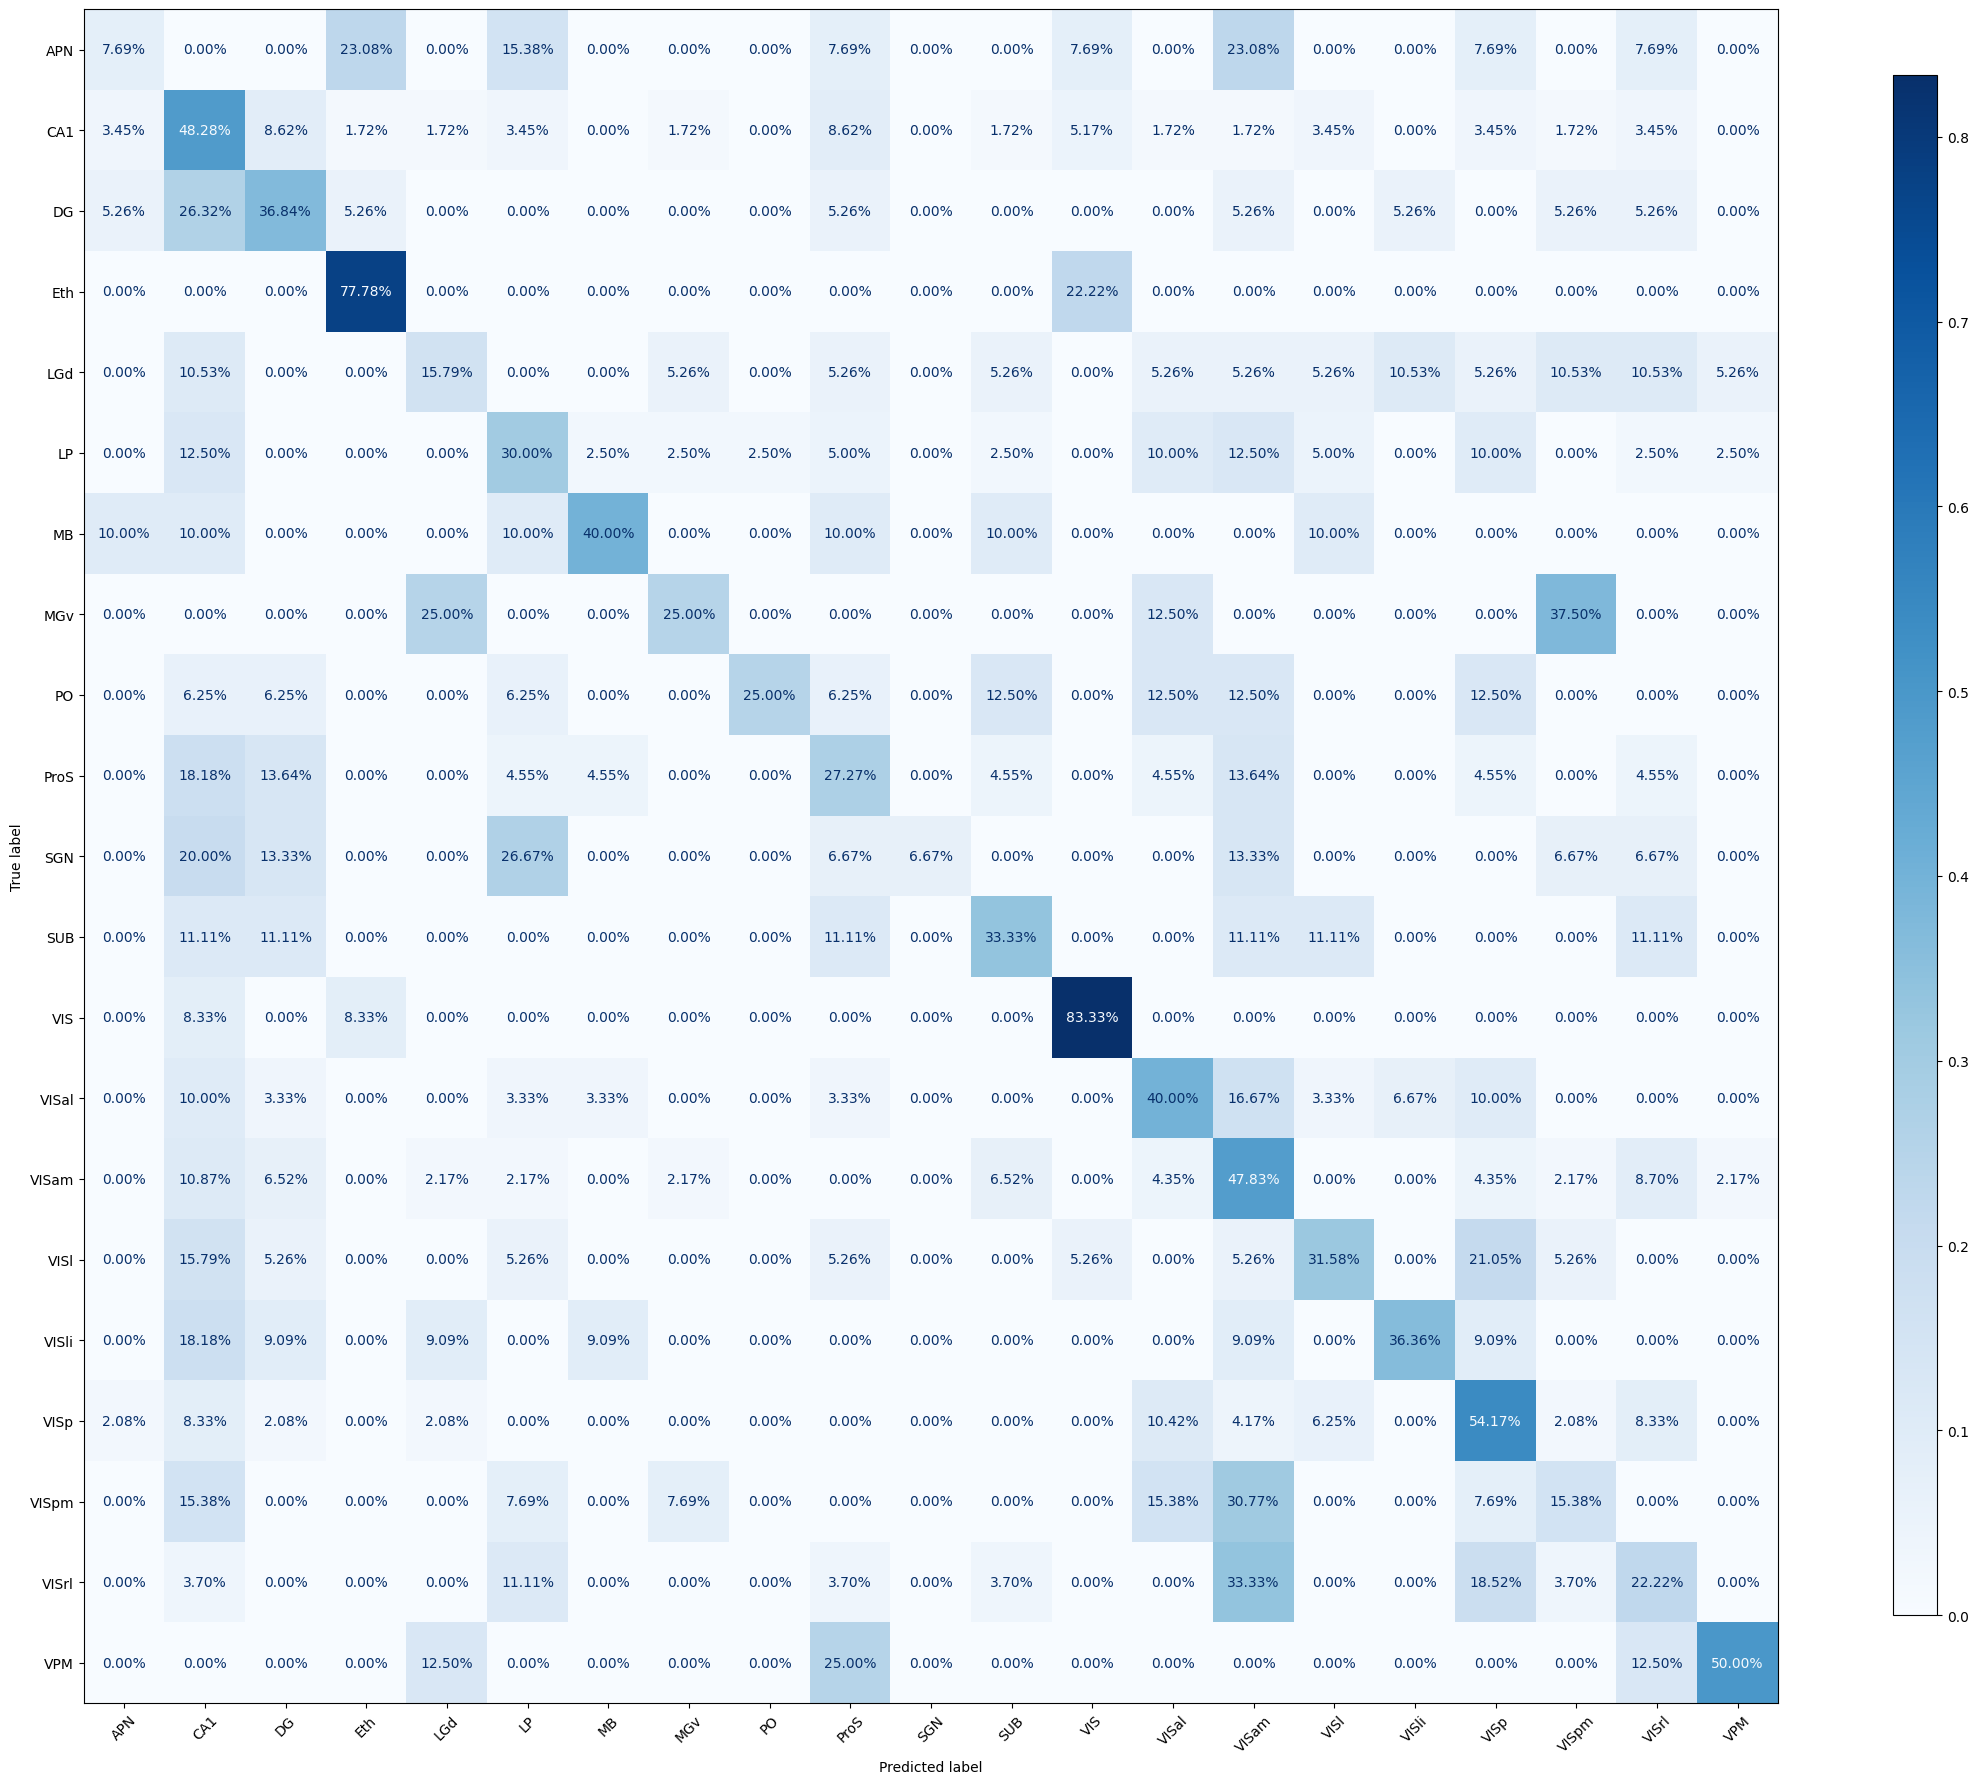

In [156]:
conf_matrix(best_model_0, X_test_0, y_test_0, normalize=True)

We decided to keep this less sparse model mainly because it was less computationally expensive. 

### **3.5.10 - Removing CA1 brain region**

We then did some variance analyses and analysing the results we removed neurons in CA1 brain area to see how this would affect the performance of the model. To motivate our choice we can see that most of the misclassified areas ended up being labeled as CA1 (not really related to visual tasks, primarly related autobiographic memory).

In [157]:
dff_0_CA1_lab = dff_lab_no_zeros.drop(dff_lab_no_zeros[dff_lab_no_zeros['label'] == 'CA1'].index)

In [158]:
dff_0_CA1 = dff_0_CA1_lab.drop('label', axis=1)

In [159]:
X_train_CA1, X_test_CA1, y_train_CA1, y_test_CA1 = train_test_split(dff_0_CA1, dff_0_CA1_lab['label'], test_size= 0.2, stratify= dff_0_CA1_lab['label'], random_state=42)

In [160]:
model_CA1_best = LogisticRegression(C=0.01, class_weight= 'balanced', multi_class= 'auto', penalty= 'l2', solver= 'lbfgs').fit(X_train_CA1, y_train_CA1)
y_test_pred_CA1 = model_CA1_best.predict(X_test_CA1)
y_train_pred_CA1 = model_CA1_best.predict(X_train_CA1)

print_accuracy(y_train_CA1, y_test_CA1, y_train_pred_CA1, y_test_pred_CA1)

Training Set Accuracy: 99.24320149140934%
Testing Set Accuracy: 52.26041085366029%


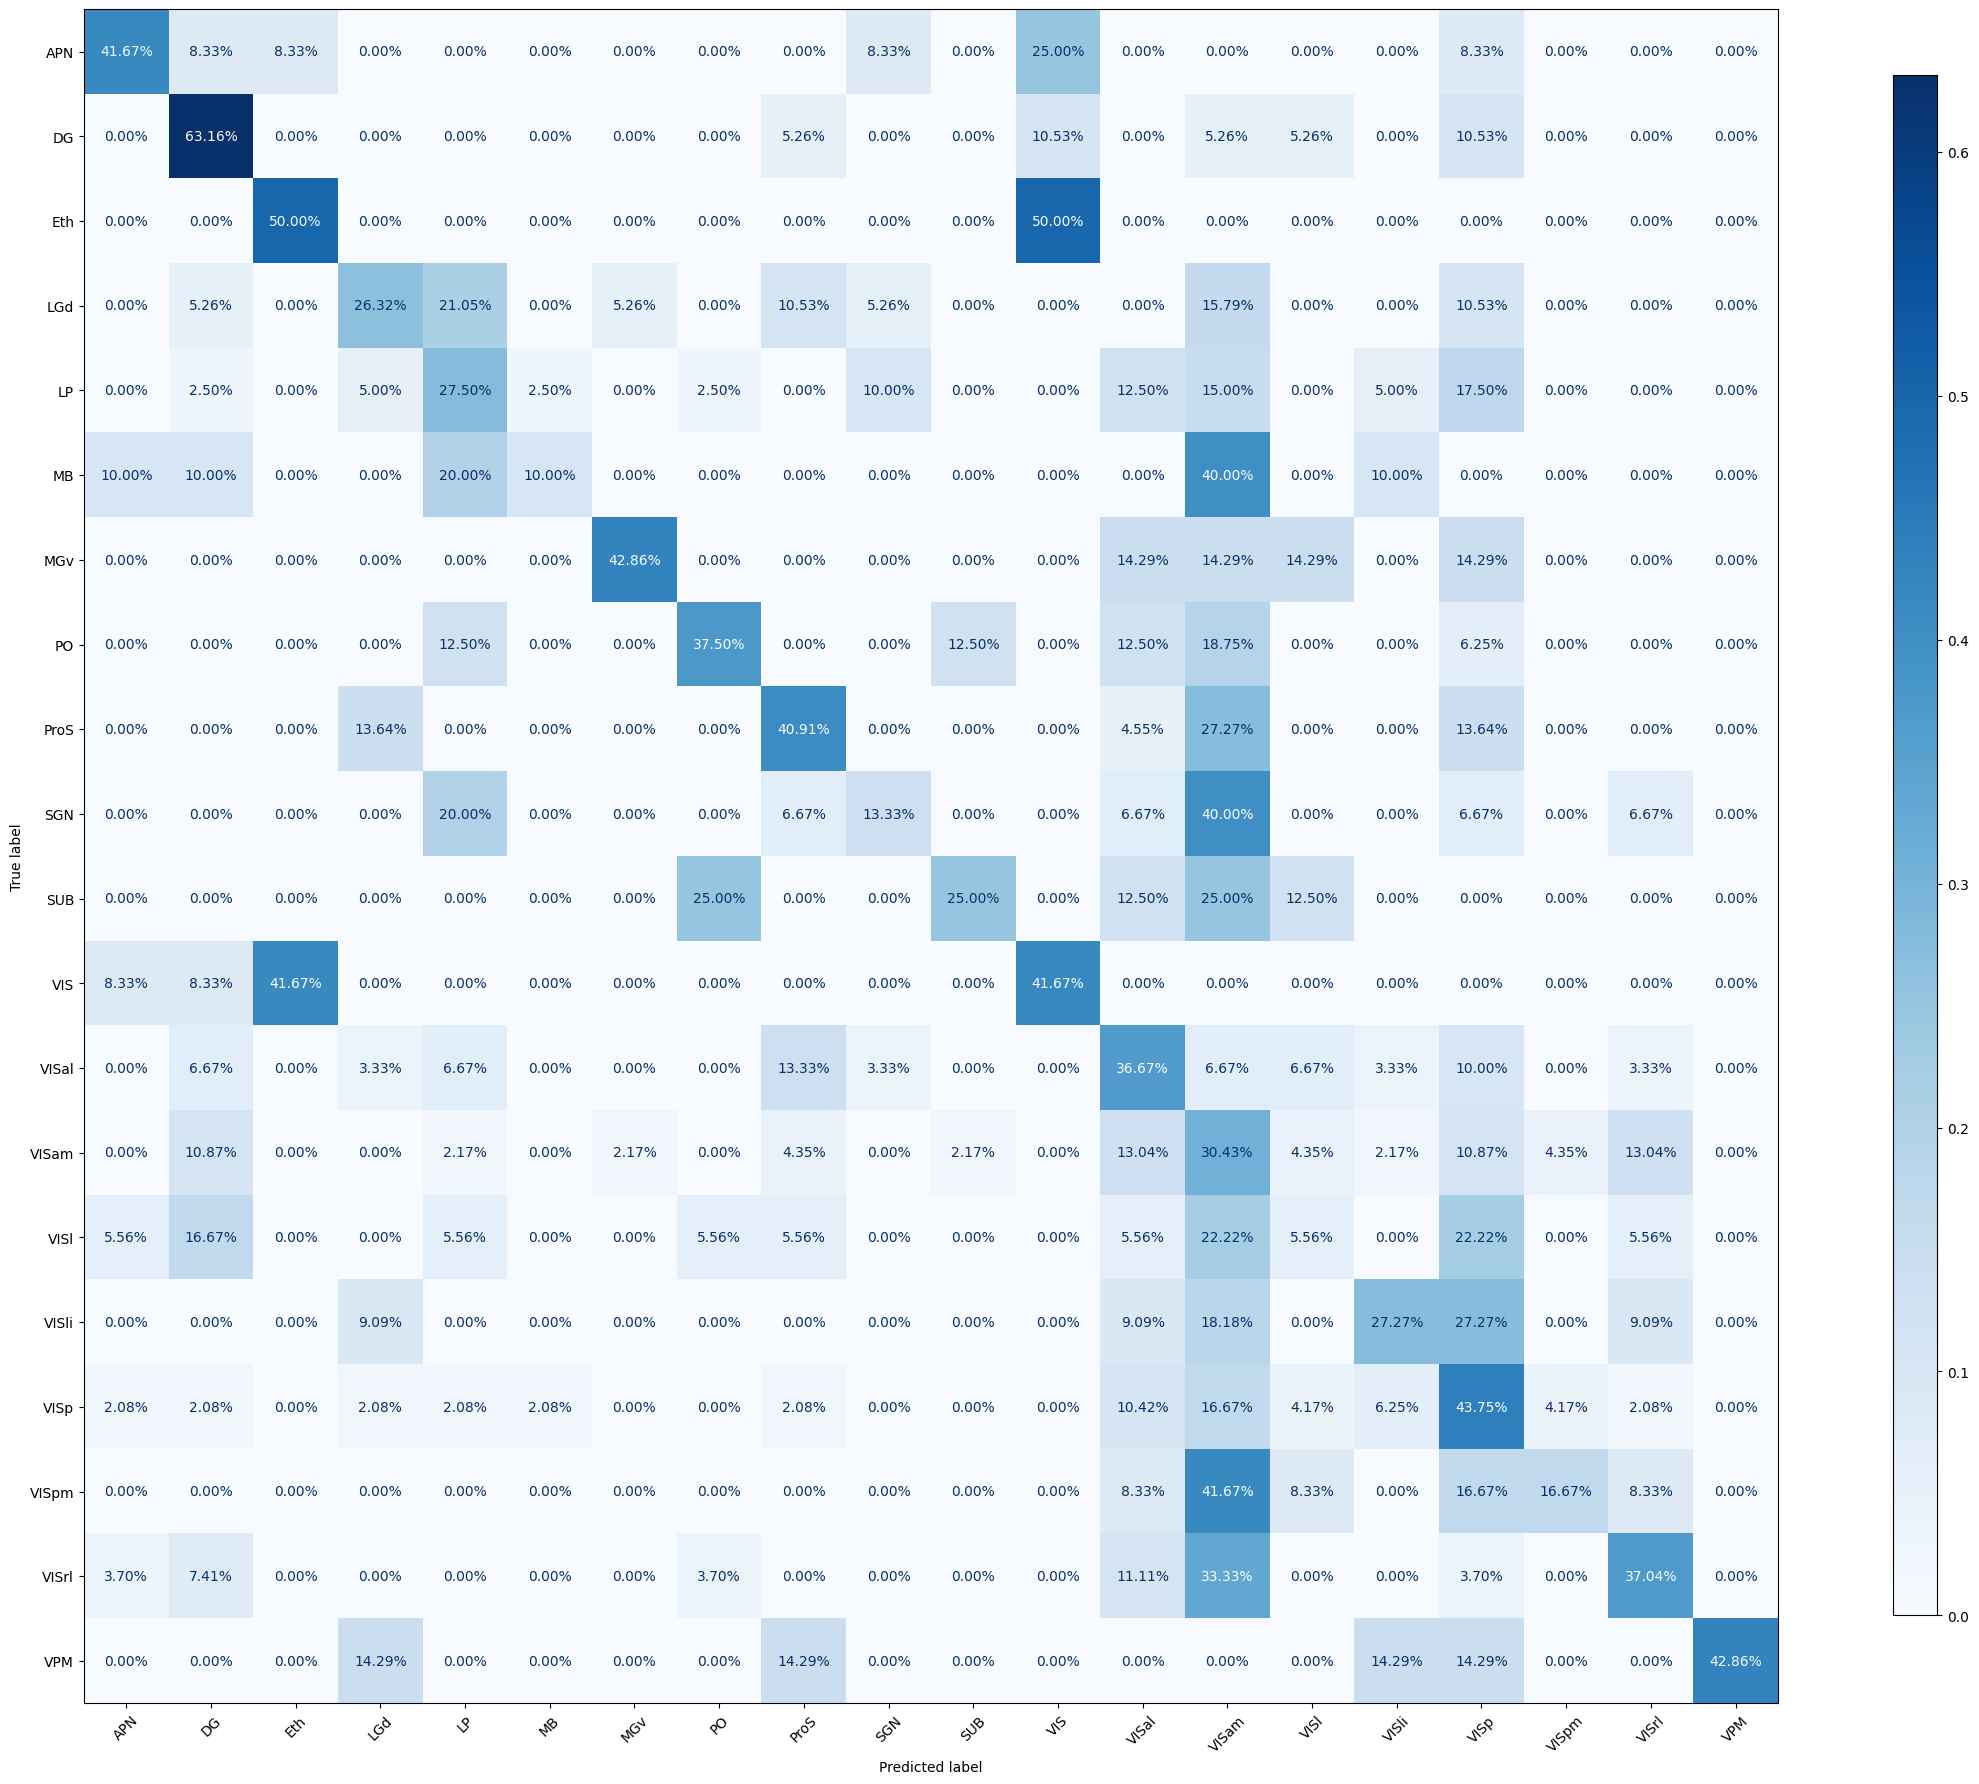

In [161]:
conf_matrix(model_CA1_best, X_test_CA1, y_test_CA1, normalize=True)

## **3.6** - Best Model removing zeroes and the CA1 region

In [162]:
model_est = LogisticRegression()

In [163]:
param_grid_final = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    "class_weight": ["balanced", None],
    "solver": ["lbfgs", "liblinear"],
    "multi_class": ["auto", "multinomial"]
}

balanced = make_scorer(balanced_accuracy_score)
grid_search_final = GridSearchCV(estimator=model_est, param_grid=param_grid_final, cv=5, scoring=balanced, verbose=1)

In [164]:
grid_search_final.fit(X_train_CA1, y_train_CA1)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


/Users/emanuelemarinolibrandi/opt/anaconda3/envs/envallen/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:542: FitFailedWarning: 
200 fits failed out of a total of 400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/emanuelemarinolibrandi/opt/anaconda3/envs/envallen/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emanuelemarinolibrandi/opt/anaconda3/envs/envallen/lib/python3.11/site-packages/sklearn/base.py", line 1351, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'class_weight': ['balanced', None],
                         'multi_class': ['auto', 'multinomial'],
                         'penalty': ['l1', 'l2'],
                         'solver': ['lbfgs', 'liblinear']},
             scoring=make_scorer(balanced_accuracy_score, response_method='predict'),
             verbose=1)

In [165]:
print("Best parameters found: ", grid_search_final.best_params_)
print("Best accuracy found: ", grid_search_final.best_score_)

best_model_final = grid_search_final.best_estimator_
y_pred_test_CA1 = best_model_final.predict(X_test_CA1)
y_pred_train_CA1 = best_model_final.predict(X_train_CA1)

print_accuracy(y_train_CA1, y_test_CA1, y_pred_train_CA1, y_pred_test_CA1)
print("\nClassification Report on test set:\n", classification_report(y_test_CA1, y_pred_test_CA1))

Best parameters found:  {'C': 0.01, 'class_weight': 'balanced', 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'lbfgs'}
Best accuracy found:  0.47960568926419
Training Set Accuracy: 99.24320149140934%
Testing Set Accuracy: 52.26041085366029%

Classification Report on test set:
               precision    recall  f1-score   support

         APN       0.38      0.42      0.40        12
          DG       0.61      0.58      0.59        19
         Eth       0.43      0.38      0.40         8
         LGd       0.27      0.21      0.24        19
          LP       0.54      0.35      0.42        40
          MB       0.55      0.60      0.57        10
         MGv       0.83      0.71      0.77         7
          PO       0.64      0.44      0.52        16
        ProS       0.46      0.73      0.56        22
         SGN       0.36      0.33      0.34        15
         SUB       0.62      0.62      0.62         8
         VIS       0.56      0.75      0.64        12
       VISal   

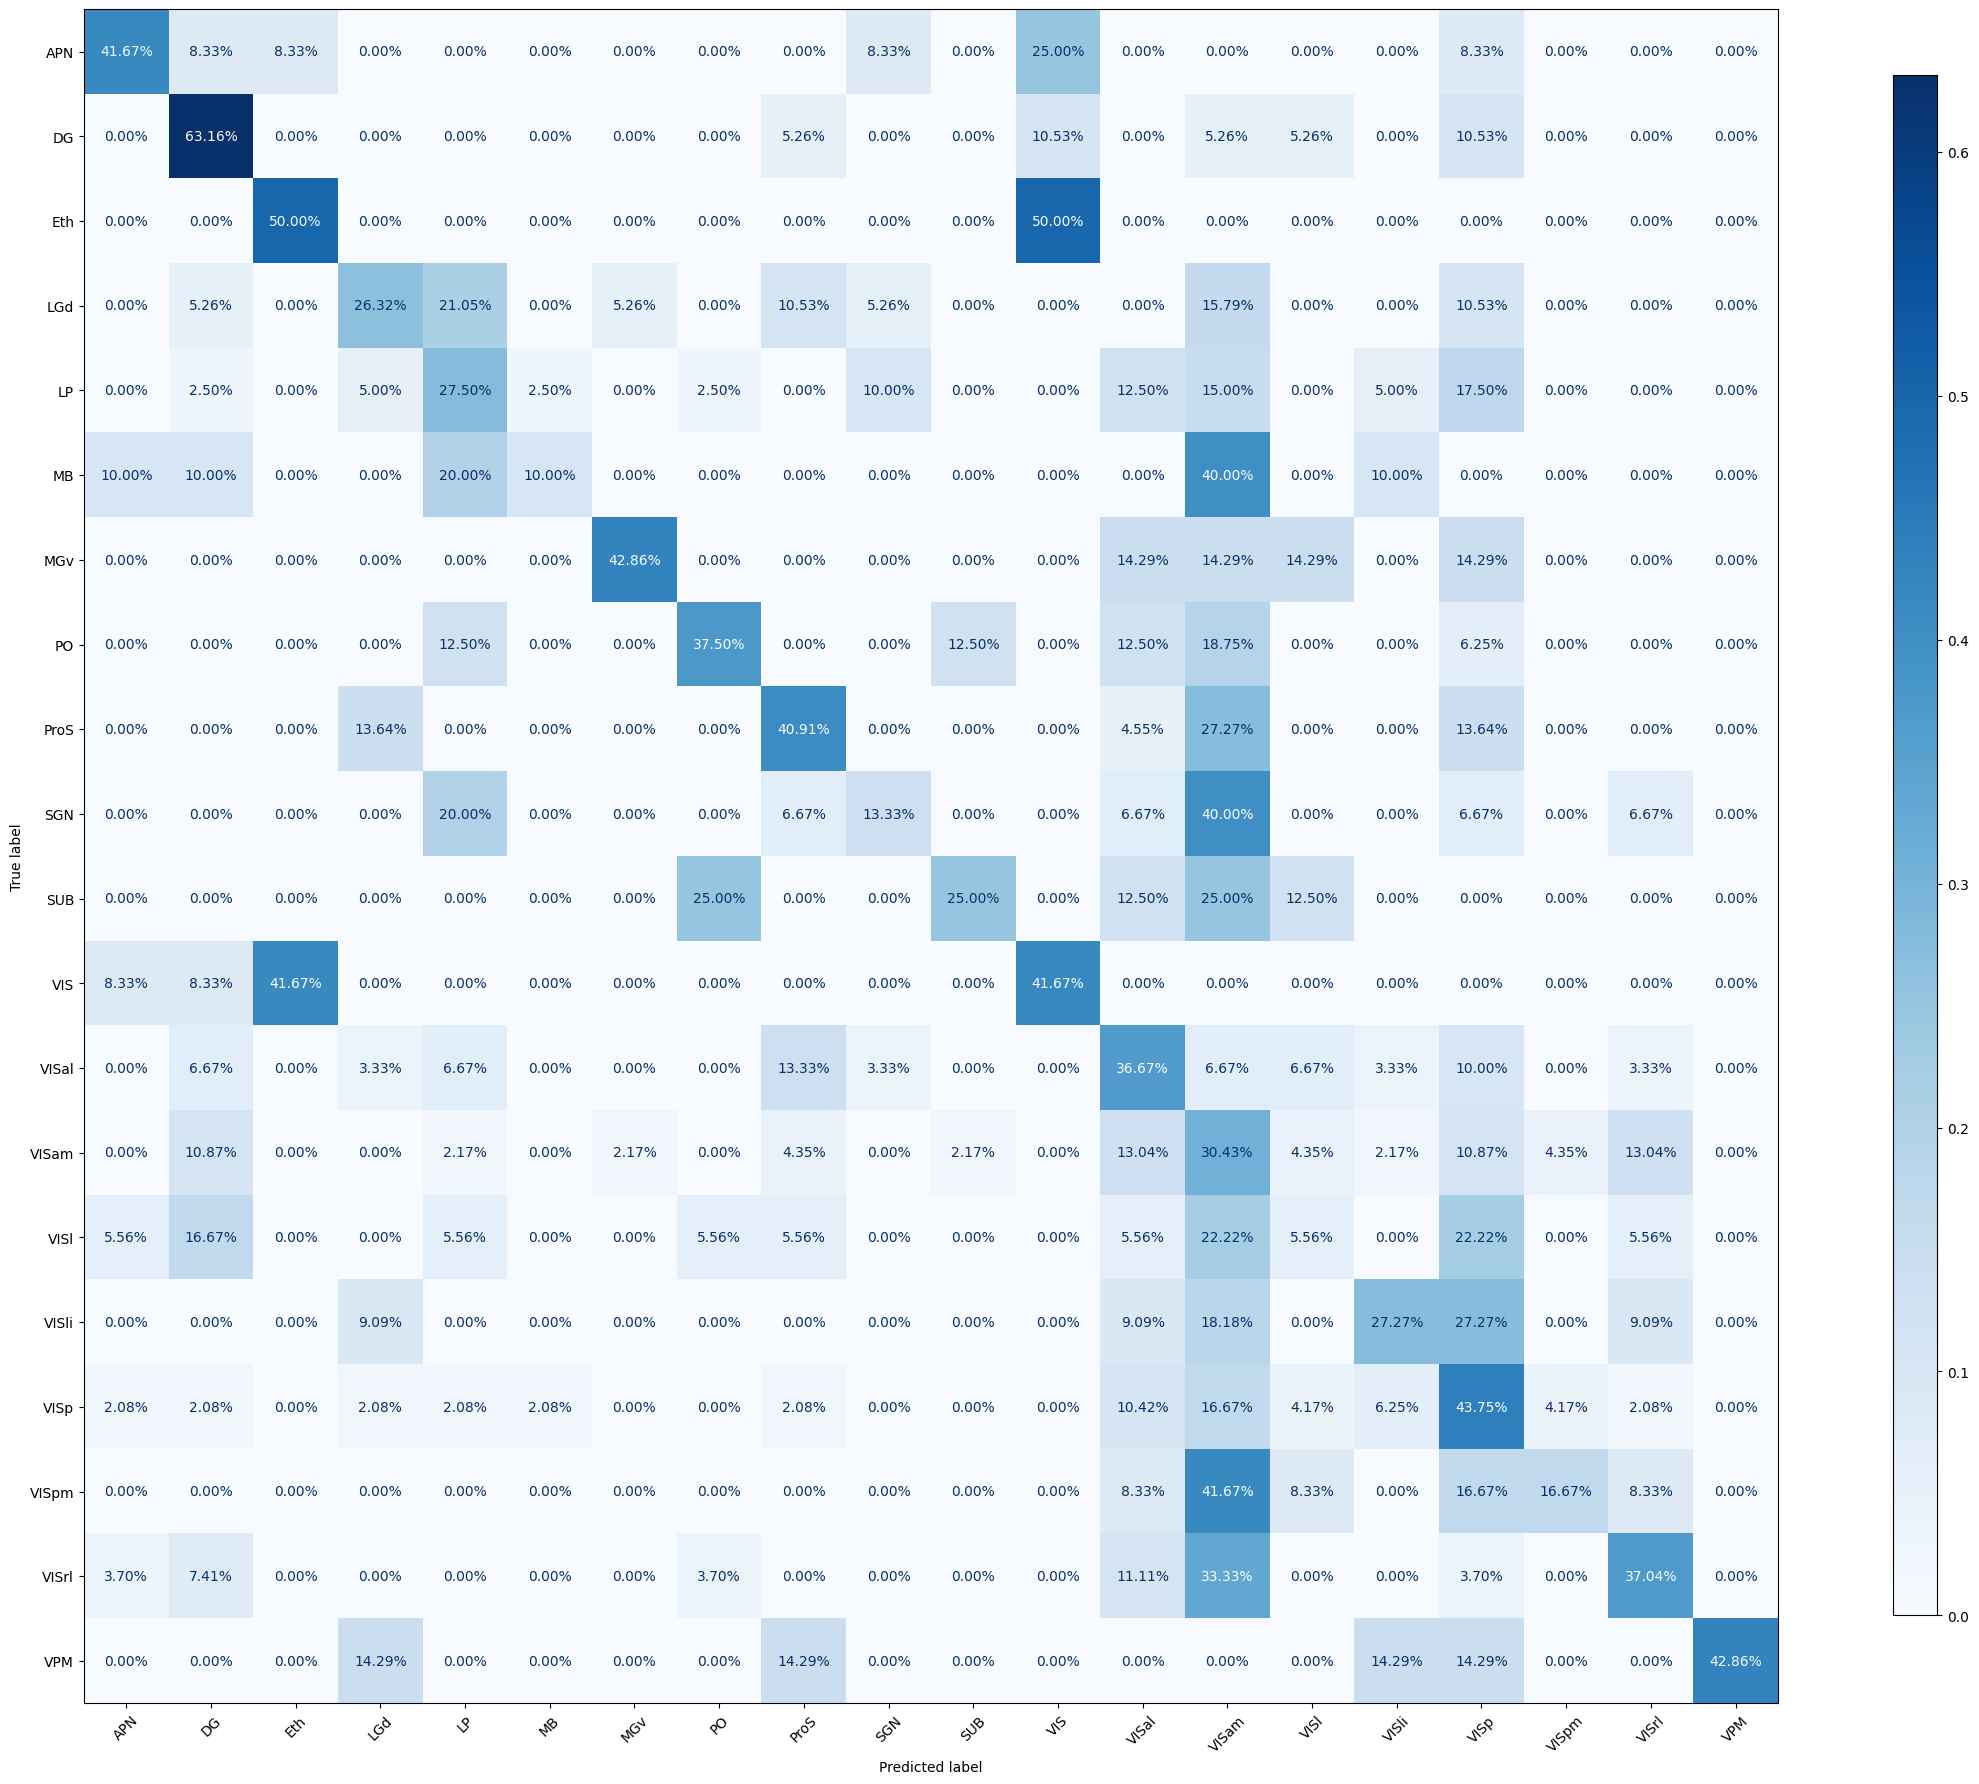

In [166]:
conf_matrix(best_model_final, X_test_CA1, y_test_CA1, normalize=True)

This is our best and final model. In conclusion, the final model demonstrated substantial improvement in classifying neuronal spikes across various brain regions with respect to random models, performing well in areas directly stimulated by the visual tasks and less effectively in regions involved in more complex cognitive functions